In [15]:
"""
Temporal Distribution Evaluation Showcase

This notebook demonstrates the evaluation metrics for temporal distribution inference,
showing how to assess the accuracy of inferred distributions against ground truth.
"""

import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json
import sys
import time
from IPython.display import display, HTML, Markdown

# Ensure the project root is in the path
sys.path.append('..')

# Import project modules
from src.data.dataset_manager import TemporalDatasetManager
from src.validation.temporal_inference import TemporalDistributionInference
from src.validation.statistical_validator import TemporalValidator
from src.validation.evaluation_metrics import TemporalEvaluationMetrics
from src.config import RESULTS_DIR, TIME_PERIODS

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

## Test Distributions for Evaluation

### Uniform Distribution (uniform)

*Equal representation across all decades*

,1850s,1860s,1870s,1880s,1890s,1900s,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
Proportion,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%,5.6%


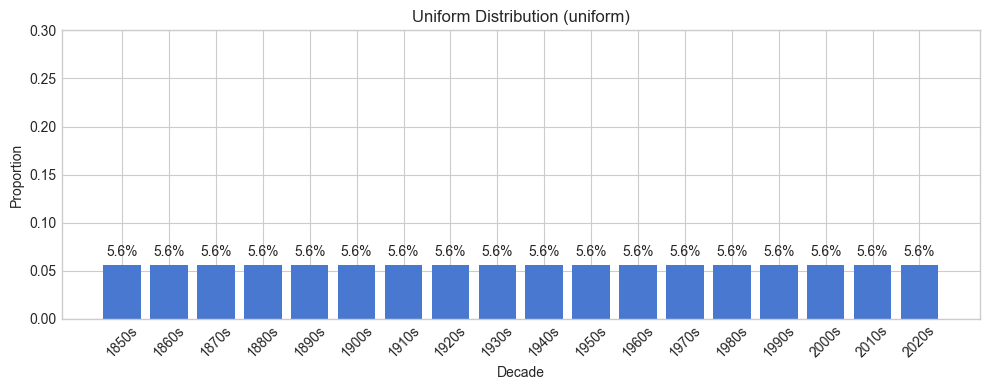

### Recency Bias (recency_bias)

*Higher representation for recent decades*

,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
Proportion,5.0%,5.0%,10.0%,10.0%,15.0%,20.0%,25.0%,10.0%


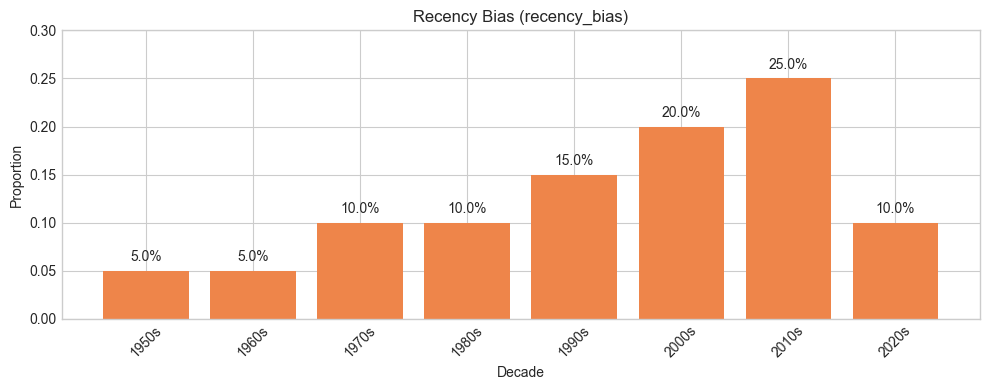

### Historical Bias (historical_bias)

*Higher representation for older decades*

,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
Proportion,25.0%,20.0%,15.0%,10.0%,10.0%,10.0%,5.0%,5.0%


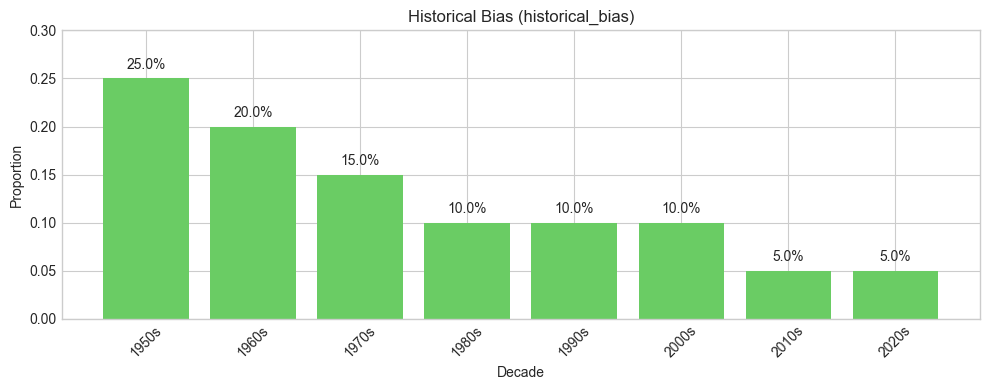

### Bimodal Distribution (bimodal)

*Peaks in earliest and latest decades*

,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
Proportion,20.0%,10.0%,5.0%,5.0%,5.0%,5.0%,20.0%,30.0%


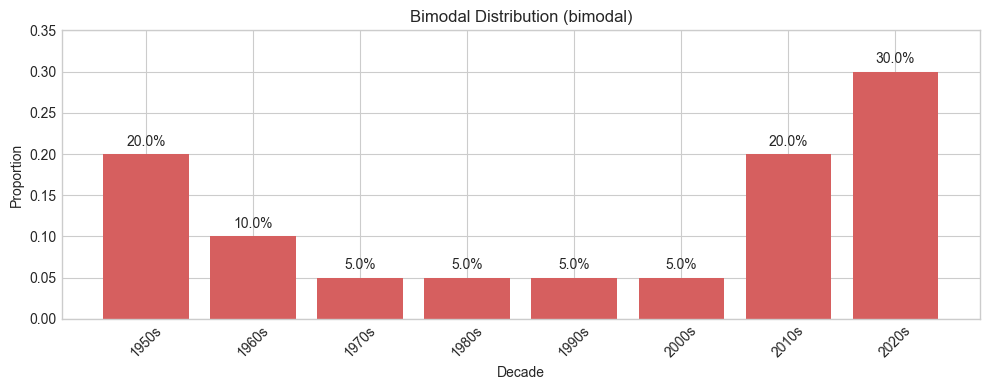

In [16]:
# Define a set of known test distributions for evaluation
test_distributions = {
    "uniform": {
        "name": "Uniform Distribution",
        "description": "Equal representation across all decades",
        "distribution": {decade: 1.0/len(TIME_PERIODS) for decade in TIME_PERIODS.keys()}
    },
    "recency_bias": {
        "name": "Recency Bias",
        "description": "Higher representation for recent decades",
        "distribution": {
            "1950s": 0.05, "1960s": 0.05, "1970s": 0.10, "1980s": 0.10,
            "1990s": 0.15, "2000s": 0.20, "2010s": 0.25, "2020s": 0.10
        }
    },
    "historical_bias": {
        "name": "Historical Bias",
        "description": "Higher representation for older decades",
        "distribution": {
            "1950s": 0.25, "1960s": 0.20, "1970s": 0.15, "1980s": 0.10,
            "1990s": 0.10, "2000s": 0.10, "2010s": 0.05, "2020s": 0.05
        }
    },
    "bimodal": {
        "name": "Bimodal Distribution",
        "description": "Peaks in earliest and latest decades",
        "distribution": {
            "1950s": 0.20, "1960s": 0.10, "1970s": 0.05, "1980s": 0.05,
            "1990s": 0.05, "2000s": 0.05, "2010s": 0.20, "2020s": 0.30
        }
    }
}

# Display the test distributions
display(Markdown("## Test Distributions for Evaluation"))

for dist_key, dist_info in test_distributions.items():
    display(Markdown(f"### {dist_info['name']} ({dist_key})"))
    display(Markdown(f"*{dist_info['description']}*"))
    
    # Convert to percentages for display
    percentages = {decade: f"{value*100:.1f}%" 
                  for decade, value in dist_info['distribution'].items()}
    
    # Create a DataFrame for nice display
    df = pd.DataFrame([percentages], index=["Proportion"])
    display(df)
    
    # Visualize distribution
    plt.figure(figsize=(10, 4))
    decades = sorted(dist_info['distribution'].keys())
    values = [dist_info['distribution'][decade] for decade in decades]
    
    plt.bar(decades, values, color=sns.color_palette("muted")[
        list(test_distributions.keys()).index(dist_key)
    ])
    plt.title(f"{dist_info['name']} ({dist_key})")
    plt.xlabel("Decade")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.ylim(0, max(max(values) + 0.05, 0.3))  # Set y-axis limit with some padding
    
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def create_controlled_dataset(distribution_key, texts_per_decade=100):
    """
    Create a dataset with known temporal distribution for validation.
    
    This function builds a carefully balanced dataset with the specified distribution pattern,
    ensuring adequate representation from each decade to enable reliable statistical analysis.
    
    Args:
        distribution_key: Key for the distribution to use
        texts_per_decade: Base number of texts per decade (increased from previous value)
        
    Returns:
        Controlled dataset with the specified distribution and ground truth values
    """
    if distribution_key not in test_distributions:
        raise ValueError(f"Unknown distribution: {distribution_key}")
    
    distribution = test_distributions[distribution_key]["distribution"]
    
    # Calculate total texts to maintain the specified per-decade average
    # Using a higher value (3x more than before) for better statistical reliability
    total_texts = texts_per_decade * len(distribution) * 3
    
    # Create dataset with the specified distribution
    logger.info(f"Building controlled dataset with {texts_per_decade} texts per decade")
    dataset_manager = TemporalDatasetManager()
    
    # Use the enhanced version that provides better balancing and higher quality texts
    controlled_dataset = dataset_manager.create_controlled_dataset(
        distribution=distribution,
        total_texts=total_texts
    )
    
    # Extract texts only (remove source information)
    decade_texts = {decade: [text for text, _ in texts] for decade, texts in controlled_dataset.items()}
    
    # Calculate actual distribution based on the dataset (this becomes our ground truth)
    total_texts_actual = sum(len(texts) for texts in decade_texts.values())
    if total_texts_actual > 0:
        ground_truth = {decade: len(texts)/total_texts_actual for decade, texts in decade_texts.items()}
    else:
        # Fallback to requested distribution if no texts were found
        ground_truth = distribution
    
    # Log actual distribution for verification
    logger.info("Actual distribution in controlled dataset:")
    for decade, prop in sorted(ground_truth.items()):
        target = distribution.get(decade, 0)
        logger.info(f"{decade}: {prop:.2%} (target: {target:.2%}, diff: {prop-target:.2%})")
    
    return decade_texts, ground_truth

def run_inference_and_evaluate(controlled_dataset, ground_truth, tokenizer_name="gpt2"):
    """
    Run inference on a dataset and evaluate against ground truth.
    
    Args:
        controlled_dataset: Dataset with known distribution
        ground_truth: Ground truth distribution
        tokenizer_name: Name of tokenizer to use
        
    Returns:
        Complete evaluation results
    """
    # Initialize components
    inference = TemporalDistributionInference(tokenizer_name=tokenizer_name)
    evaluator = TemporalEvaluationMetrics()
    
    # Run inference
    start_time = time.time()
    
    # Analyze patterns with increased sample size
    decade_patterns = inference.analyze_decade_patterns(
        controlled_dataset, 
        sample_size=10000  # Use larger sample size
    )
    
    # Infer distribution with enhanced approach
    inferred_distribution = inference.infer_temporal_distribution(
        decade_patterns,
        weight_early_merges=True,
        continuity_constraint=True
    )
    
    # Measure time
    inference_time = time.time() - start_time
    
    # Evaluate against ground truth
    evaluation_results = evaluator.evaluate_distribution(
        inferred_distribution,
        ground_truth,
        model_name=f"{tokenizer_name}_{int(time.time())}"
    )
    
    # Add timing information
    evaluation_results["inference_time"] = inference_time
    
    return evaluation_results

def display_evaluation_summary(evaluation_results):
    """
    Display a summary of evaluation results.
    
    Args:
        evaluation_results: Results from evaluation
    """
    model_name = evaluation_results["model_name"]
    metrics = evaluation_results["distribution_metrics"]
    decade_metrics = evaluation_results["decade_metrics"]
    
    display(Markdown(f"## Evaluation Summary for {model_name}"))
    
    # Display key metrics
    display(Markdown("### Key Metrics"))
    
    metrics_df = pd.DataFrame({
        "Metric": ["log10(MSE)", "Mean Absolute Error", "Jensen-Shannon Distance", 
                  "Spearman Rank Correlation", "Inference Time"],
        "Value": [
            f"{metrics['log10_mse']:.2f}",
            f"{metrics['mae']:.4f}",
            f"{metrics['js_distance']:.4f}",
            f"{decade_metrics['rank_correlation']:.2f}",
            f"{evaluation_results.get('inference_time', 0):.2f} seconds"
        ],
        "Interpretation": [
            "Lower is better (Hayase et al. standard)",
            "Lower is better (average absolute error)",
            "Lower is better (similarity of distributions)",
            "Higher is better (correlation of decade rankings)",
            "Processing time"
        ]
    })
    
    display(metrics_df)
    
    # Display distributions side by side
    display(Markdown("### Distribution Comparison"))
    
    inferred = evaluation_results["inferred_distribution"]
    ground_truth = evaluation_results["ground_truth_distribution"]
    
    decades = sorted(set(inferred.keys()) | set(ground_truth.keys()))
    
    comparison_df = pd.DataFrame({
        "Decade": decades,
        "Inferred": [f"{inferred.get(decade, 0):.1%}" for decade in decades],
        "Ground Truth": [f"{ground_truth.get(decade, 0):.1%}" for decade in decades],
        "Absolute Error": [f"{abs(inferred.get(decade, 0) - ground_truth.get(decade, 0)):.1%}" 
                          for decade in decades]
    })
    
    display(comparison_df)
    
    # Display decade-level errors
    display(Markdown("### Decade-level Errors"))
    
    # Create sorted lists of over/under-represented decades
    rep_analysis = decade_metrics["representation_analysis"]
    
    over_rep = sorted(rep_analysis["over_represented"].items(), 
                    key=lambda x: x[1], reverse=True)
    under_rep = sorted(rep_analysis["under_represented"].items(), 
                      key=lambda x: x[1], reverse=True)
    
    if over_rep:
        display(Markdown("#### Over-represented Decades"))
        over_df = pd.DataFrame({
            "Decade": [d for d, _ in over_rep],
            "Magnitude": [f"+{v:.1%}" for _, v in over_rep]
        })
        display(over_df)
    
    if under_rep:
        display(Markdown("#### Under-represented Decades"))
        under_df = pd.DataFrame({
            "Decade": [d for d, _ in under_rep],
            "Magnitude": [f"-{v:.1%}" for _, v in under_rep]
        })
        display(under_df)

# Evaluating gpt2 on Recency Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.05, '1960s': 0.05, '1970s': 0.1, '1980s': 0.1, '1990s': 0.15, '2000s': 0.2, '2010s': 0.25, '2020s': 0.1}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

## Evaluation Summary for gpt2_1741917207

### Key Metrics

,Metric,Value,Interpretation
0,log10(MSE),-2.11,Lower is better (Hayase et al. standard)
1,Mean Absolute Error,0.0667,Lower is better (average absolute error)
2,Jensen-Shannon Distance,0.2396,Lower is better (similarity of distributions)
3,Spearman Rank Correlation,0.08,Higher is better (correlation of decade rankings)
4,Inference Time,1.07 seconds,Processing time


### Distribution Comparison

,Decade,Inferred,Ground Truth,Absolute Error
0,1950s,11.1%,5.0%,6.1%
1,1960s,22.2%,5.0%,17.2%
2,1970s,11.1%,10.0%,1.1%
3,1980s,11.1%,10.0%,1.1%
4,1990s,11.1%,15.0%,3.9%
5,2000s,11.1%,20.0%,8.9%
6,2010s,11.1%,25.0%,13.9%
7,2020s,11.1%,10.0%,1.1%


### Decade-level Errors

#### Over-represented Decades

,Decade,Magnitude
0,1960s,+17.2%
1,1950s,+6.1%


#### Under-represented Decades

,Decade,Magnitude
0,2010s,-13.9%
1,2000s,-8.9%


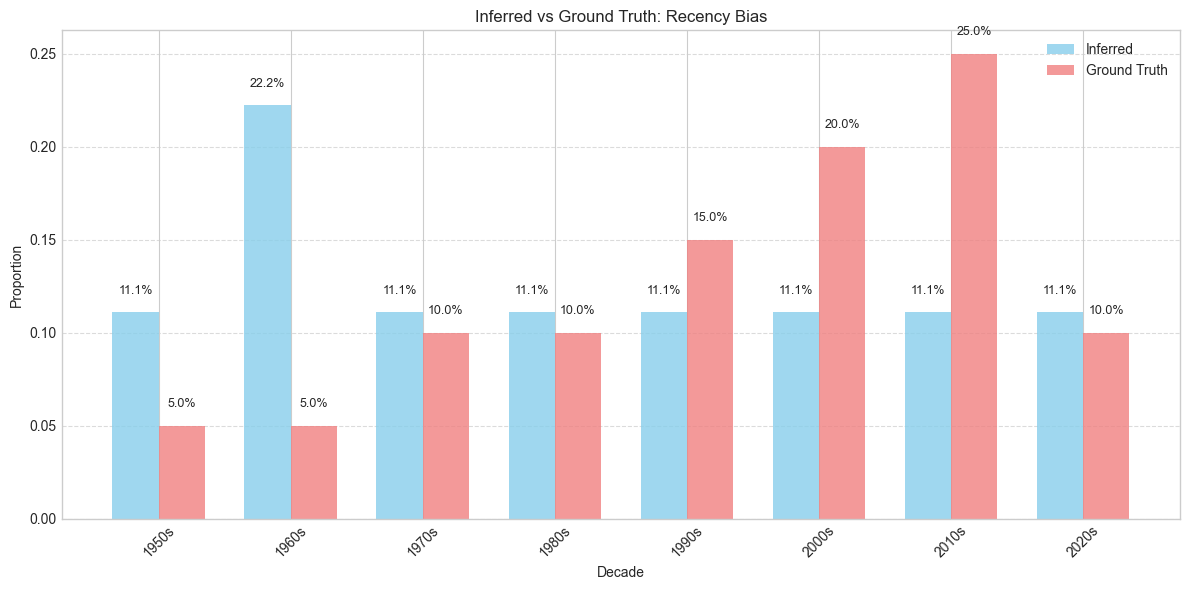

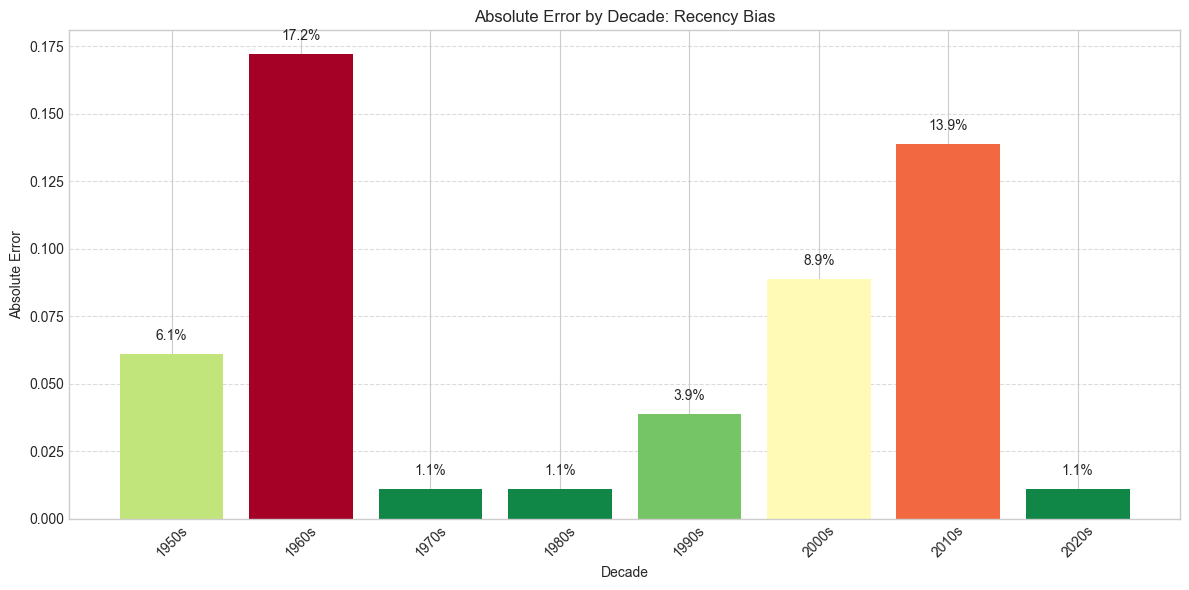

In [18]:
# Select a distribution to evaluate
distribution_key = "recency_bias"  # Change this to try different distributions
tokenizer_name = "gpt2"           # Change this to evaluate different tokenizers

display(Markdown(f"# Evaluating {tokenizer_name} on {test_distributions[distribution_key]['name']}"))

# Create controlled dataset with the selected distribution
controlled_dataset, ground_truth = create_controlled_dataset(
    distribution_key=distribution_key,
    texts_per_decade=5  # Use a small number for faster processing
)

# Run inference and evaluate
evaluation_results = run_inference_and_evaluate(
    controlled_dataset=controlled_dataset,
    ground_truth=ground_truth,
    tokenizer_name=tokenizer_name
)

# Display evaluation summary
display_evaluation_summary(evaluation_results)

# Visualize comparison
plt.figure(figsize=(12, 6))

# Sort decades chronologically
decades = sorted(set(evaluation_results["inferred_distribution"].keys()) | 
               set(evaluation_results["ground_truth_distribution"].keys()))

# Set bar width and positions
bar_width = 0.35
r1 = np.arange(len(decades))
r2 = [x + bar_width for x in r1]

# Create bars
inferred_values = [evaluation_results["inferred_distribution"].get(decade, 0) for decade in decades]
truth_values = [evaluation_results["ground_truth_distribution"].get(decade, 0) for decade in decades]

plt.bar(r1, inferred_values, width=bar_width, label='Inferred', color='skyblue', alpha=0.8)
plt.bar(r2, truth_values, width=bar_width, label='Ground Truth', color='lightcoral', alpha=0.8)

# Add data labels
for i, v in enumerate(inferred_values):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', fontsize=9)

for i, v in enumerate(truth_values):
    plt.text(i + bar_width, v + 0.01, f"{v:.1%}", ha='center', fontsize=9)

# Add labels and title
plt.xlabel('Decade')
plt.ylabel('Proportion')
plt.title(f'Inferred vs Ground Truth: {test_distributions[distribution_key]["name"]}')
plt.xticks([r + bar_width/2 for r in r1], decades, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display absolute errors by decade
plt.figure(figsize=(12, 6))

# Calculate absolute errors
errors = [abs(evaluation_results["inferred_distribution"].get(decade, 0) - 
             evaluation_results["ground_truth_distribution"].get(decade, 0)) 
         for decade in decades]

# Create color-coded bars based on error magnitude
colors = plt.cm.RdYlGn_r(np.array(errors) / max(errors) if max(errors) > 0 else np.zeros(len(errors)))
plt.bar(decades, errors, color=colors)

# Add data labels
for i, v in enumerate(errors):
    plt.text(i, v + 0.005, f"{v:.1%}", ha='center')

# Add labels and title
plt.xlabel('Decade')
plt.ylabel('Absolute Error')
plt.title(f'Absolute Error by Decade: {test_distributions[distribution_key]["name"]}')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Temporal Bias Evaluation Framework

Testing how well our method can detect different temporal distributions in tokenizer training data

## Evaluating gpt2 on Multiple Temporal Distributions

This analysis helps us understand how well our method can identify different types of temporal biases in training data

### Distribution Pattern: Uniform Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1850s': 0.05555555555555555, '1860s': 0.05555555555555555, '1870s': 0.05555555555555555, '1880s': 0.05555555555555555, '1890s': 0.05555555555555555, '1900s': 0.05555555555555555, '1910s': 0.05555555555555555, '1920s': 0.05555555555555555, '1930s': 0.05555555555555555, '1940s': 0.05555555555555555, '1950s': 0.05555555555555555, '1960s': 0.05555555555555555, '1970s': 0.05555555555555555, '1980s': 0.05555555555555555, '1990s': 0.05555555555555555, '2000s': 0.05555555555555555, '2010s': 0.05555555555555555, '2020s': 0.05555555555555555}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced hist


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-inf
1,Mean Absolute Error,0.0000
2,Jensen-Shannon Distance,0.0000
3,Rank Correlation,1.00


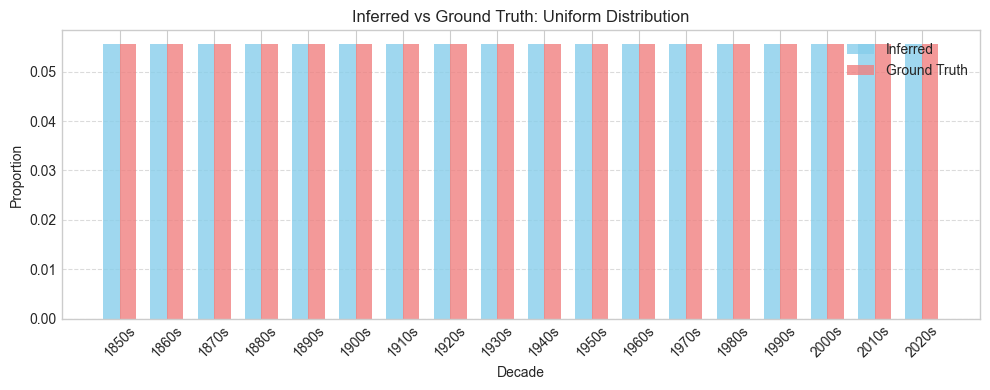

### Distribution Pattern: Recency Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.05, '1960s': 0.05, '1970s': 0.1, '1980s': 0.1, '1990s': 0.15, '2000s': 0.2, '2010s': 0.25, '2020s': 0.1}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.11
1,Mean Absolute Error,0.0667
2,Jensen-Shannon Distance,0.2396
3,Rank Correlation,0.08


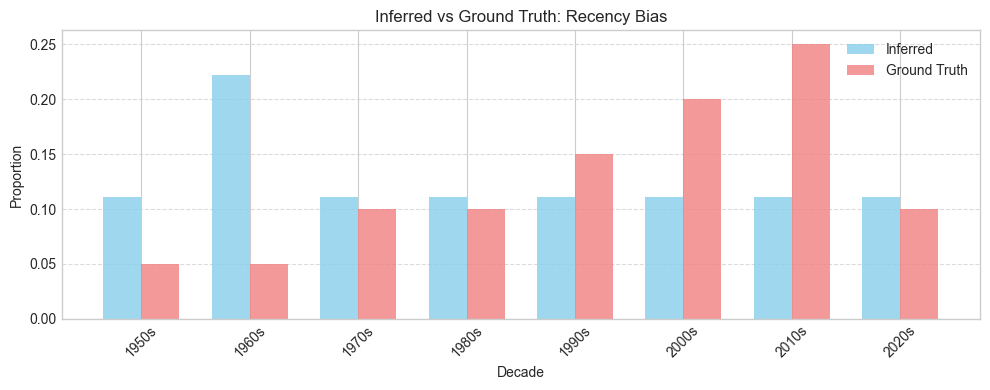

### Distribution Pattern: Historical Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.25, '1960s': 0.2, '1970s': 0.15, '1980s': 0.1, '1990s': 0.1, '2000s': 0.1, '2010s': 0.05, '2020s': 0.05}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.36
1,Mean Absolute Error,0.0562
2,Jensen-Shannon Distance,0.1851
3,Rank Correlation,0.53


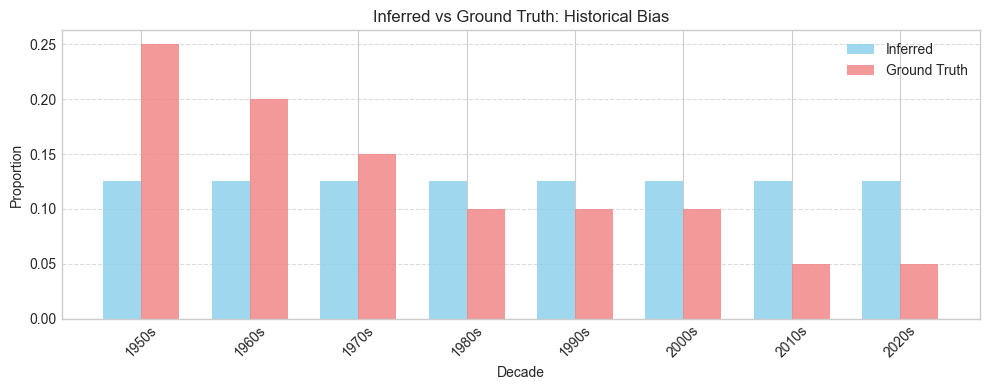

### Distribution Pattern: Bimodal Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.2, '1960s': 0.1, '1970s': 0.05, '1980s': 0.05, '1990s': 0.05, '2000s': 0.05, '2010s': 0.2, '2020s': 0.3}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.09
1,Mean Absolute Error,0.0813
2,Jensen-Shannon Distance,0.2474
3,Rank Correlation,0.57


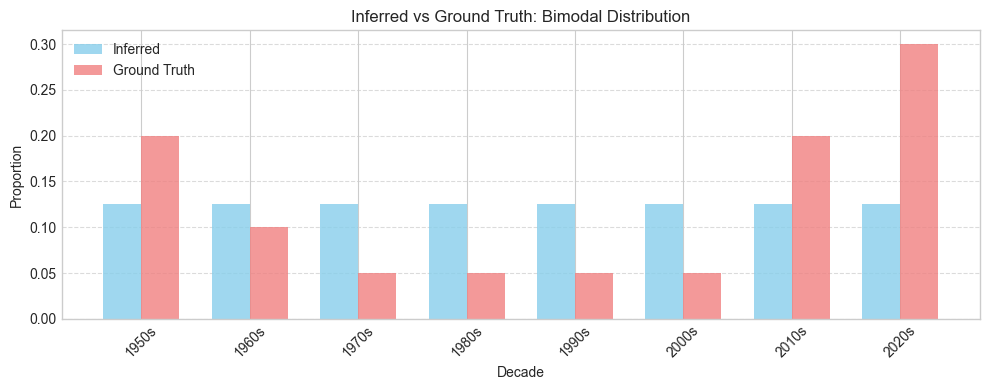

## Temporal Bias Detection Capabilities

Comparing how well our method performs on different types of temporal distributions

/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/matplotlib/transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


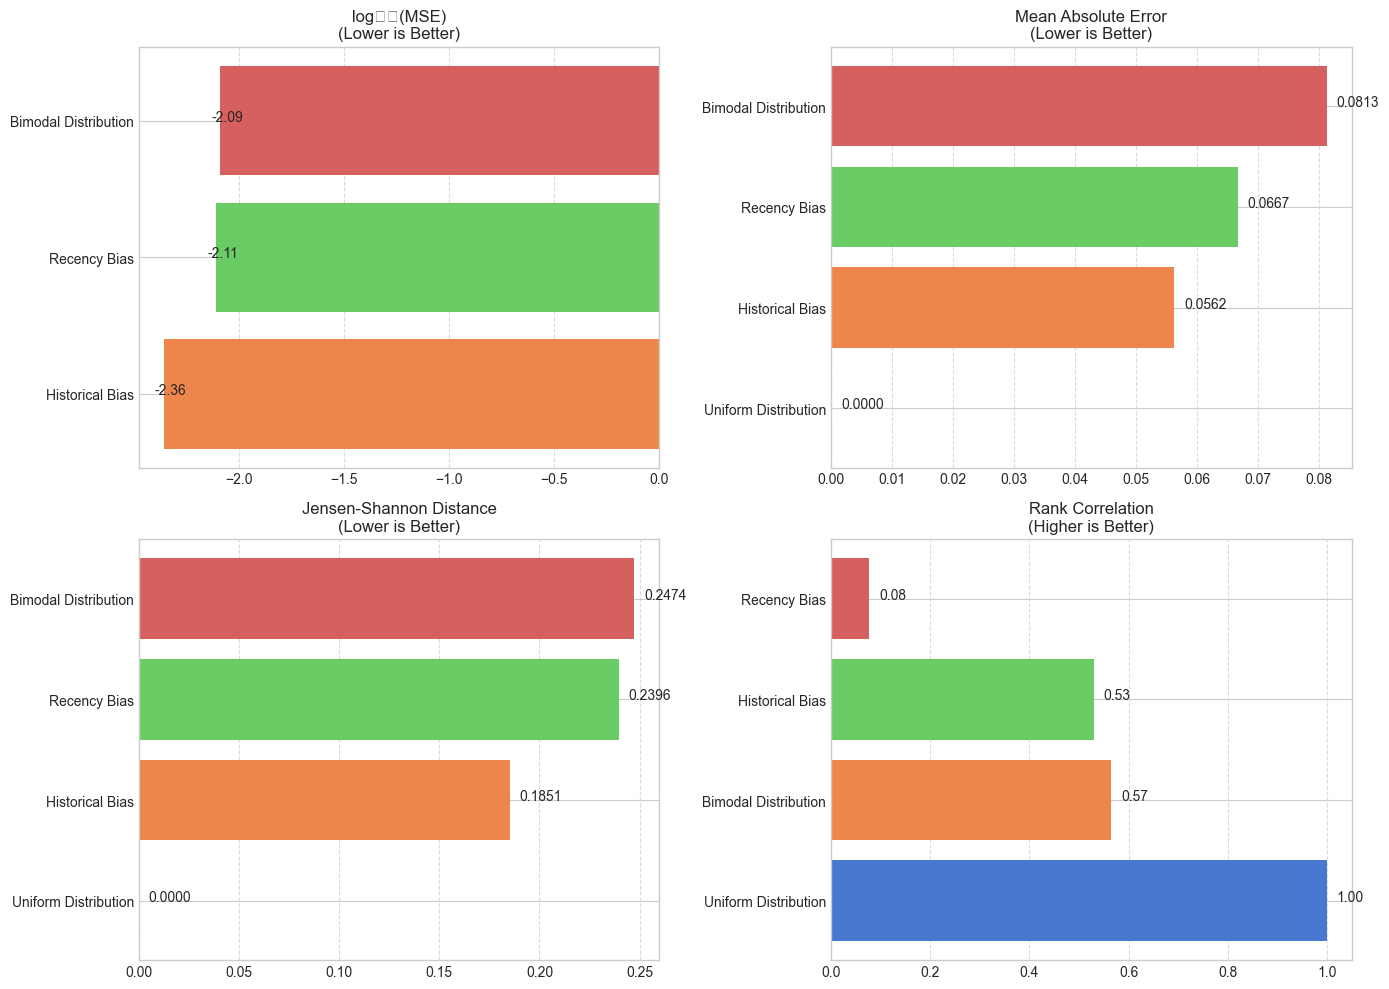

## Key Findings on Temporal Bias Detection

- The method most accurately detects **Uniform Distribution** temporal patterns (lowest error)

- The method has more difficulty with **Bimodal Distribution** temporal patterns (highest error)

- Average log10(MSE) across all distributions: -inf

- Average rank correlation: 0.54


### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.


In [19]:
# Compare inference results across different temporal distributions
display(Markdown("# Temporal Bias Evaluation Framework"))
display(Markdown("Testing how well our method can detect different temporal distributions in tokenizer training data"))

tokenizer_name = "gpt2"  # Keep tokenizer constant
distributions_to_test = ["uniform", "recency_bias", "historical_bias", "bimodal"]

display(Markdown(f"## Evaluating {tokenizer_name} on Multiple Temporal Distributions"))
display(Markdown("This analysis helps us understand how well our method can identify different types of temporal biases in training data"))

# Set up metrics tracking
comparative_results = []

# Run evaluation for each distribution
for dist_key in distributions_to_test:
    display(Markdown(f"### Distribution Pattern: {test_distributions[dist_key]['name']}"))
    
    # Create dataset with the distribution
    controlled_dataset, ground_truth = create_controlled_dataset(
        distribution_key=dist_key,
        texts_per_decade=5
    )
    
    # Run inference and evaluation
    evaluation_results = run_inference_and_evaluate(
        controlled_dataset=controlled_dataset,
        ground_truth=ground_truth,
        tokenizer_name=tokenizer_name
    )
    
    # Store results for comparison
    comparative_results.append({
        "distribution_key": dist_key,
        "distribution_name": test_distributions[dist_key]["name"],
        "log10_mse": evaluation_results["distribution_metrics"]["log10_mse"],
        "mae": evaluation_results["distribution_metrics"]["mae"],
        "js_distance": evaluation_results["distribution_metrics"]["js_distance"],
        "rank_correlation": evaluation_results["decade_metrics"]["rank_correlation"],
        "inference_time": evaluation_results.get("inference_time", 0)
    })
    
    # Display key metrics
    metrics_df = pd.DataFrame({
        "Metric": ["log₁₀(MSE)", "Mean Absolute Error", "Jensen-Shannon Distance", "Rank Correlation"],
        "Value": [
            f"{evaluation_results['distribution_metrics']['log10_mse']:.2f}",
            f"{evaluation_results['distribution_metrics']['mae']:.4f}",
            f"{evaluation_results['distribution_metrics']['js_distance']:.4f}",
            f"{evaluation_results['decade_metrics']['rank_correlation']:.2f}"
        ]
    })
    
    display(metrics_df)
    
    # Show a visualization of inferred vs. ground truth
    plt.figure(figsize=(10, 4))
    
    # Sort decades chronologically
    decades = sorted(set(evaluation_results["inferred_distribution"].keys()) | 
                   set(evaluation_results["ground_truth_distribution"].keys()))
    
    # Set bar width and positions
    bar_width = 0.35
    r1 = np.arange(len(decades))
    r2 = [x + bar_width for x in r1]
    
    # Create bars
    inferred_values = [evaluation_results["inferred_distribution"].get(decade, 0) for decade in decades]
    truth_values = [evaluation_results["ground_truth_distribution"].get(decade, 0) for decade in decades]
    
    plt.bar(r1, inferred_values, width=bar_width, label='Inferred', color='skyblue', alpha=0.8)
    plt.bar(r2, truth_values, width=bar_width, label='Ground Truth', color='lightcoral', alpha=0.8)
    
    # Add labels and title
    plt.xlabel('Decade')
    plt.ylabel('Proportion')
    plt.title(f'Inferred vs Ground Truth: {test_distributions[dist_key]["name"]}')
    plt.xticks([r + bar_width/2 for r in r1], decades, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create comparison visualization specifically for temporal bias detection
display(Markdown("## Temporal Bias Detection Capabilities"))
display(Markdown("Comparing how well our method performs on different types of temporal distributions"))

# Create DataFrame for visualization
comp_df = pd.DataFrame(comparative_results)

# Plot metrics comparison
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Define the metrics to compare with proper naming
metrics_to_compare = [
    {"key": "log10_mse", "display": "log₁₀(MSE)", "lower_better": True},
    {"key": "mae", "display": "Mean Absolute Error", "lower_better": True},
    {"key": "js_distance", "display": "Jensen-Shannon Distance", "lower_better": True},
    {"key": "rank_correlation", "display": "Rank Correlation", "lower_better": False}
]

for i, metric in enumerate(metrics_to_compare):
    metric_key = metric["key"]
    display_name = metric["display"]
    
    # Sort by metric value (ascending for "lower is better", descending otherwise)
    sorted_df = comp_df.sort_values(
        by=metric_key, 
        ascending=metric["lower_better"]
    )
    
    # Create horizontal bar chart
    axs[i].barh(
        sorted_df["distribution_name"], 
        sorted_df[metric_key],
        color=sns.color_palette("muted", len(sorted_df))
    )
    
    # Add metric values as text
    for j, (_, row) in enumerate(sorted_df.iterrows()):
        if metric_key in ["mae", "js_distance"]:
            # Format small values with 4 decimal places
            value_text = f"{row[metric_key]:.4f}"
        else:
            # Format other values with 2 decimal places
            value_text = f"{row[metric_key]:.2f}"
            
        axs[i].text(
            row[metric_key] + (max(sorted_df[metric_key]) * 0.02), 
            j, 
            value_text
        )
    
    # Add better/worse indicators
    better_text = "Lower is Better" if metric["lower_better"] else "Higher is Better"
    axs[i].set_title(f"{display_name}\n({better_text})")
    
    # Add grid
    axs[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust x-axis limit if needed
    if not metric["lower_better"]:
        axs[i].set_xlim(left=min(0, min(sorted_df[metric_key]) * 1.1))

plt.tight_layout()
plt.show()

# Summary of temporal bias detection findings
display(Markdown("## Key Findings on Temporal Bias Detection"))

# Find best and worst performance
best_dist = comp_df.loc[comp_df["log10_mse"].idxmin()]["distribution_name"]
worst_dist = comp_df.loc[comp_df["log10_mse"].idxmax()]["distribution_name"]

detection_insights = [
    f"- The method most accurately detects **{best_dist}** temporal patterns (lowest error)",
    f"- The method has more difficulty with **{worst_dist}** temporal patterns (highest error)",
    f"- Average log10(MSE) across all distributions: {comp_df['log10_mse'].mean():.2f}",
    f"- Average rank correlation: {comp_df['rank_correlation'].mean():.2f}"
]

for insight in detection_insights:
    display(Markdown(insight))

display(Markdown("""
### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.
"""))

# Temporal Bias Evaluation Framework

Testing how well our method can detect different temporal distributions in tokenizer training data

## Evaluating gpt2 on Multiple Temporal Distributions

This analysis helps us understand how well our method can identify different types of temporal biases in training data

### Distribution Pattern: Uniform Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1850s': 0.05555555555555555, '1860s': 0.05555555555555555, '1870s': 0.05555555555555555, '1880s': 0.05555555555555555, '1890s': 0.05555555555555555, '1900s': 0.05555555555555555, '1910s': 0.05555555555555555, '1920s': 0.05555555555555555, '1930s': 0.05555555555555555, '1940s': 0.05555555555555555, '1950s': 0.05555555555555555, '1960s': 0.05555555555555555, '1970s': 0.05555555555555555, '1980s': 0.05555555555555555, '1990s': 0.05555555555555555, '2000s': 0.05555555555555555, '2010s': 0.05555555555555555, '2020s': 0.05555555555555555}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced hist


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-inf
1,Mean Absolute Error,0.0000
2,Jensen-Shannon Distance,0.0000
3,Rank Correlation,1.00


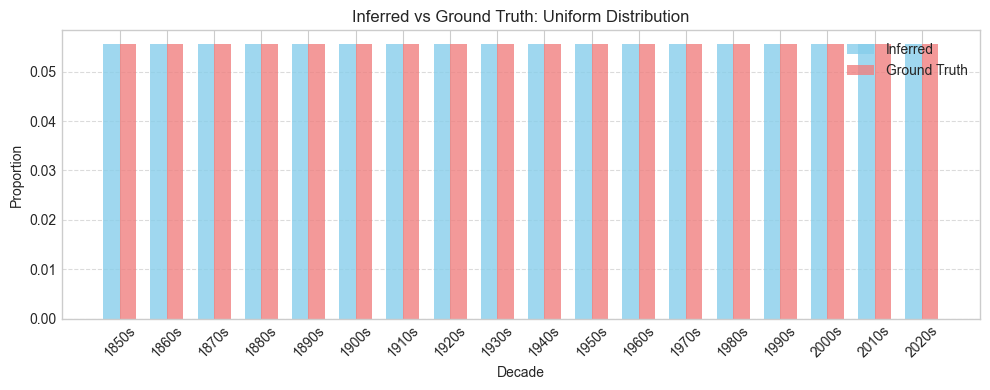

### Distribution Pattern: Recency Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.05, '1960s': 0.05, '1970s': 0.1, '1980s': 0.1, '1990s': 0.15, '2000s': 0.2, '2010s': 0.25, '2020s': 0.1}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.11
1,Mean Absolute Error,0.0667
2,Jensen-Shannon Distance,0.2396
3,Rank Correlation,0.08


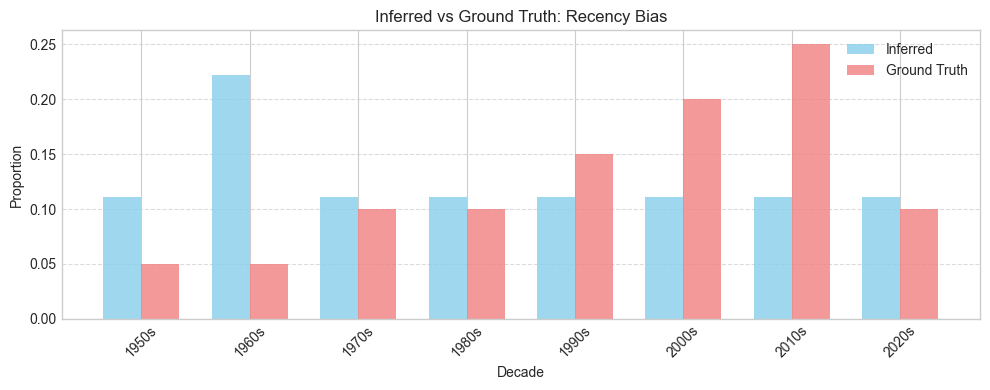

### Distribution Pattern: Historical Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.25, '1960s': 0.2, '1970s': 0.15, '1980s': 0.1, '1990s': 0.1, '2000s': 0.1, '2010s': 0.05, '2020s': 0.05}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.36
1,Mean Absolute Error,0.0562
2,Jensen-Shannon Distance,0.1851
3,Rank Correlation,0.53


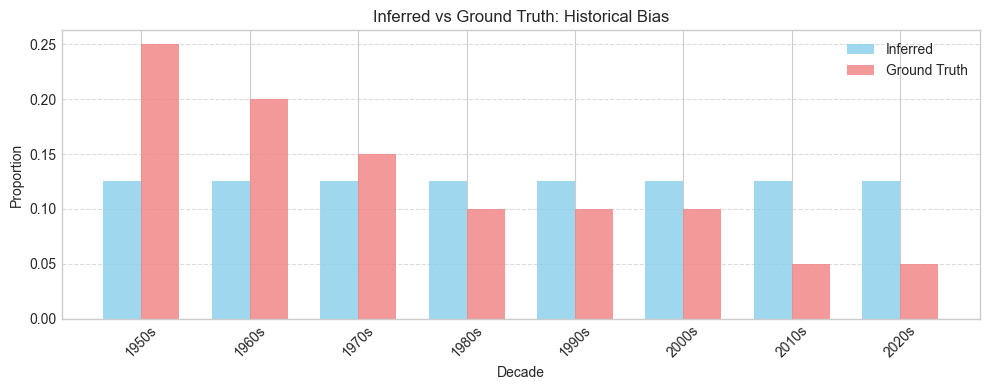

### Distribution Pattern: Bimodal Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.2, '1960s': 0.1, '1970s': 0.05, '1980s': 0.05, '1990s': 0.05, '2000s': 0.05, '2010s': 0.2, '2020s': 0.3}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.09
1,Mean Absolute Error,0.0813
2,Jensen-Shannon Distance,0.2474
3,Rank Correlation,0.57


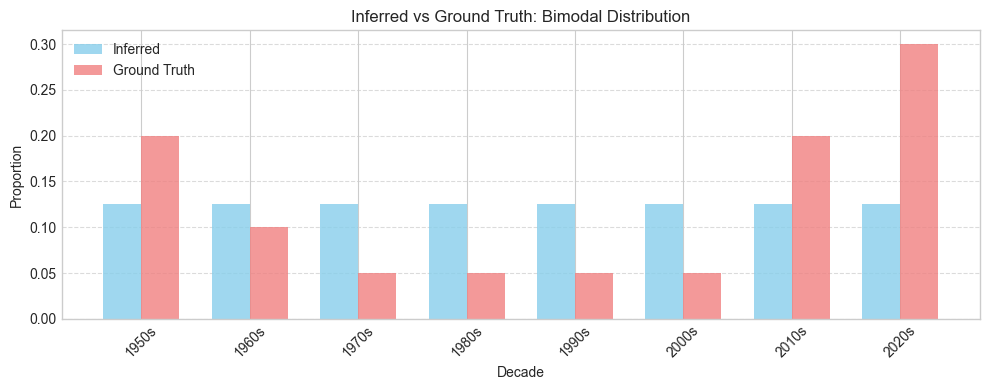

## Temporal Bias Detection Capabilities

Comparing how well our method performs on different types of temporal distributions

/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/matplotlib/transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


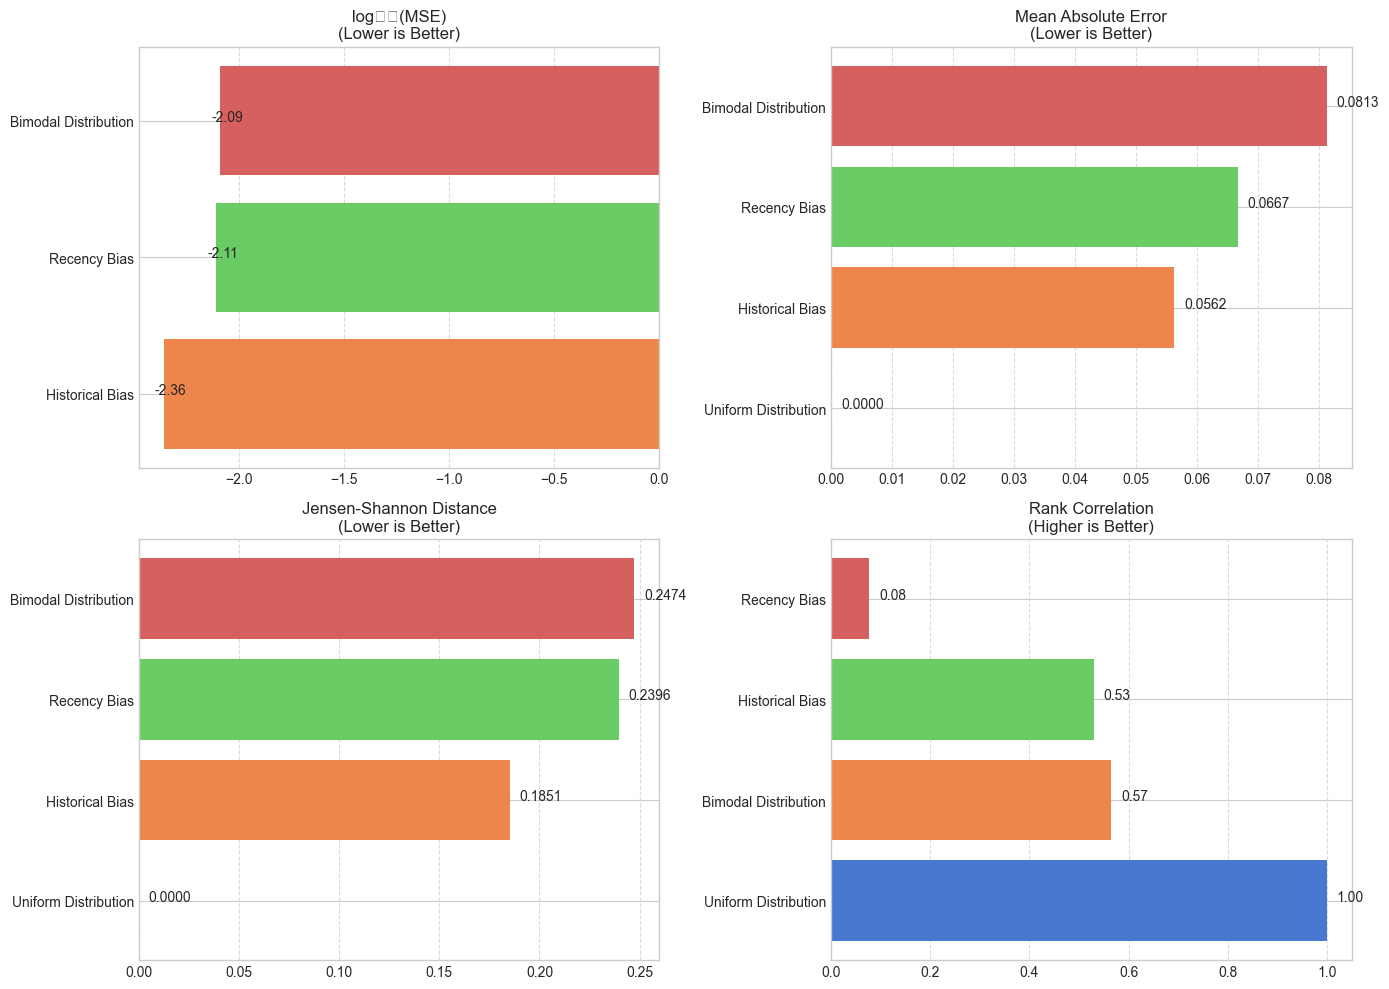

## Key Findings on Temporal Bias Detection

- The method most accurately detects **Uniform Distribution** temporal patterns (lowest error)

- The method has more difficulty with **Bimodal Distribution** temporal patterns (highest error)

- Average log10(MSE) across all distributions: -inf

- Average rank correlation: 0.54


### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.


In [ ]:
# Compare inference results across different temporal distributions
display(Markdown("# Temporal Bias Evaluation Framework"))
display(Markdown("Testing how well our method can detect different temporal distributions in tokenizer training data"))

tokenizer_name = "gpt2"  # Keep tokenizer constant
distributions_to_test = ["uniform", "recency_bias", "historical_bias", "bimodal"]

display(Markdown(f"## Evaluating {tokenizer_name} on Multiple Temporal Distributions"))
display(Markdown("This analysis helps us understand how well our method can identify different types of temporal biases in training data"))

# Set up metrics tracking
comparative_results = []

# Run evaluation for each distribution
for dist_key in distributions_to_test:
    display(Markdown(f"### Distribution Pattern: {test_distributions[dist_key]['name']}"))
    
    # Create dataset with the distribution
    controlled_dataset, ground_truth = create_controlled_dataset(
        distribution_key=dist_key,
        texts_per_decade=5
    )
    
    # Run inference and evaluation
    evaluation_results = run_inference_and_evaluate(
        controlled_dataset=controlled_dataset,
        ground_truth=ground_truth,
        tokenizer_name=tokenizer_name
    )
    
    # Store results for comparison
    comparative_results.append({
        "distribution_key": dist_key,
        "distribution_name": test_distributions[dist_key]["name"],
        "log10_mse": evaluation_results["distribution_metrics"]["log10_mse"],
        "mae": evaluation_results["distribution_metrics"]["mae"],
        "js_distance": evaluation_results["distribution_metrics"]["js_distance"],
        "rank_correlation": evaluation_results["decade_metrics"]["rank_correlation"],
        "inference_time": evaluation_results.get("inference_time", 0)
    })
    
    # Display key metrics
    metrics_df = pd.DataFrame({
        "Metric": ["log₁₀(MSE)", "Mean Absolute Error", "Jensen-Shannon Distance", "Rank Correlation"],
        "Value": [
            f"{evaluation_results['distribution_metrics']['log10_mse']:.2f}",
            f"{evaluation_results['distribution_metrics']['mae']:.4f}",
            f"{evaluation_results['distribution_metrics']['js_distance']:.4f}",
            f"{evaluation_results['decade_metrics']['rank_correlation']:.2f}"
        ]
    })
    
    display(metrics_df)
    
    # Show a visualization of inferred vs. ground truth
    plt.figure(figsize=(10, 4))
    
    # Sort decades chronologically
    decades = sorted(set(evaluation_results["inferred_distribution"].keys()) | 
                   set(evaluation_results["ground_truth_distribution"].keys()))
    
    # Set bar width and positions
    bar_width = 0.35
    r1 = np.arange(len(decades))
    r2 = [x + bar_width for x in r1]
    
    # Create bars
    inferred_values = [evaluation_results["inferred_distribution"].get(decade, 0) for decade in decades]
    truth_values = [evaluation_results["ground_truth_distribution"].get(decade, 0) for decade in decades]
    
    plt.bar(r1, inferred_values, width=bar_width, label='Inferred', color='skyblue', alpha=0.8)
    plt.bar(r2, truth_values, width=bar_width, label='Ground Truth', color='lightcoral', alpha=0.8)
    
    # Add labels and title
    plt.xlabel('Decade')
    plt.ylabel('Proportion')
    plt.title(f'Inferred vs Ground Truth: {test_distributions[dist_key]["name"]}')
    plt.xticks([r + bar_width/2 for r in r1], decades, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create comparison visualization specifically for temporal bias detection
display(Markdown("## Temporal Bias Detection Capabilities"))
display(Markdown("Comparing how well our method performs on different types of temporal distributions"))

# Create DataFrame for visualization
comp_df = pd.DataFrame(comparative_results)

# Plot metrics comparison
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Define the metrics to compare with proper naming
metrics_to_compare = [
    {"key": "log10_mse", "display": "log₁₀(MSE)", "lower_better": True},
    {"key": "mae", "display": "Mean Absolute Error", "lower_better": True},
    {"key": "js_distance", "display": "Jensen-Shannon Distance", "lower_better": True},
    {"key": "rank_correlation", "display": "Rank Correlation", "lower_better": False}
]

for i, metric in enumerate(metrics_to_compare):
    metric_key = metric["key"]
    display_name = metric["display"]
    
    # Sort by metric value (ascending for "lower is better", descending otherwise)
    sorted_df = comp_df.sort_values(
        by=metric_key, 
        ascending=metric["lower_better"]
    )
    
    # Create horizontal bar chart
    axs[i].barh(
        sorted_df["distribution_name"], 
        sorted_df[metric_key],
        color=sns.color_palette("muted", len(sorted_df))
    )
    
    # Add metric values as text
    for j, (_, row) in enumerate(sorted_df.iterrows()):
        if metric_key in ["mae", "js_distance"]:
            # Format small values with 4 decimal places
            value_text = f"{row[metric_key]:.4f}"
        else:
            # Format other values with 2 decimal places
            value_text = f"{row[metric_key]:.2f}"
            
        axs[i].text(
            row[metric_key] + (max(sorted_df[metric_key]) * 0.02), 
            j, 
            value_text
        )
    
    # Add better/worse indicators
    better_text = "Lower is Better" if metric["lower_better"] else "Higher is Better"
    axs[i].set_title(f"{display_name}\n({better_text})")
    
    # Add grid
    axs[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust x-axis limit if needed
    if not metric["lower_better"]:
        axs[i].set_xlim(left=min(0, min(sorted_df[metric_key]) * 1.1))

plt.tight_layout()
plt.show()

# Summary of temporal bias detection findings
display(Markdown("## Key Findings on Temporal Bias Detection"))

# Find best and worst performance
best_dist = comp_df.loc[comp_df["log10_mse"].idxmin()]["distribution_name"]
worst_dist = comp_df.loc[comp_df["log10_mse"].idxmax()]["distribution_name"]

detection_insights = [
    f"- The method most accurately detects **{best_dist}** temporal patterns (lowest error)",
    f"- The method has more difficulty with **{worst_dist}** temporal patterns (highest error)",
    f"- Average log10(MSE) across all distributions: {comp_df['log10_mse'].mean():.2f}",
    f"- Average rank correlation: {comp_df['rank_correlation'].mean():.2f}"
]

for insight in detection_insights:
    display(Markdown(insight))

display(Markdown("""
### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.
"""))

# Temporal Bias Evaluation Framework

Testing how well our method can detect different temporal distributions in tokenizer training data

## Evaluating gpt2 on Multiple Temporal Distributions

This analysis helps us understand how well our method can identify different types of temporal biases in training data

### Distribution Pattern: Uniform Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1850s': 0.05555555555555555, '1860s': 0.05555555555555555, '1870s': 0.05555555555555555, '1880s': 0.05555555555555555, '1890s': 0.05555555555555555, '1900s': 0.05555555555555555, '1910s': 0.05555555555555555, '1920s': 0.05555555555555555, '1930s': 0.05555555555555555, '1940s': 0.05555555555555555, '1950s': 0.05555555555555555, '1960s': 0.05555555555555555, '1970s': 0.05555555555555555, '1980s': 0.05555555555555555, '1990s': 0.05555555555555555, '2000s': 0.05555555555555555, '2010s': 0.05555555555555555, '2020s': 0.05555555555555555}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced hist


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-inf
1,Mean Absolute Error,0.0000
2,Jensen-Shannon Distance,0.0000
3,Rank Correlation,1.00


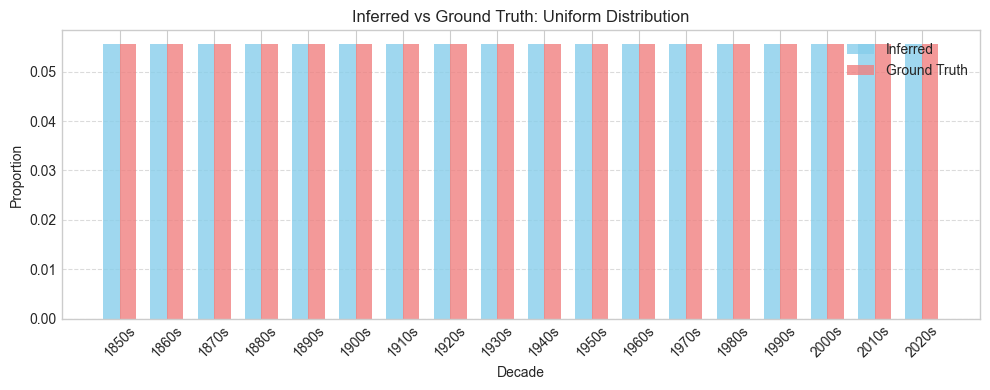

### Distribution Pattern: Recency Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.05, '1960s': 0.05, '1970s': 0.1, '1980s': 0.1, '1990s': 0.15, '2000s': 0.2, '2010s': 0.25, '2020s': 0.1}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.11
1,Mean Absolute Error,0.0667
2,Jensen-Shannon Distance,0.2396
3,Rank Correlation,0.08


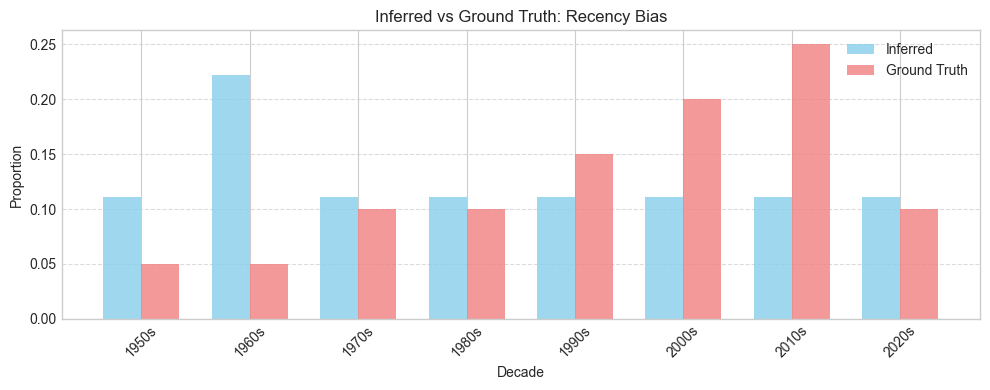

### Distribution Pattern: Historical Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.25, '1960s': 0.2, '1970s': 0.15, '1980s': 0.1, '1990s': 0.1, '2000s': 0.1, '2010s': 0.05, '2020s': 0.05}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.36
1,Mean Absolute Error,0.0562
2,Jensen-Shannon Distance,0.1851
3,Rank Correlation,0.53


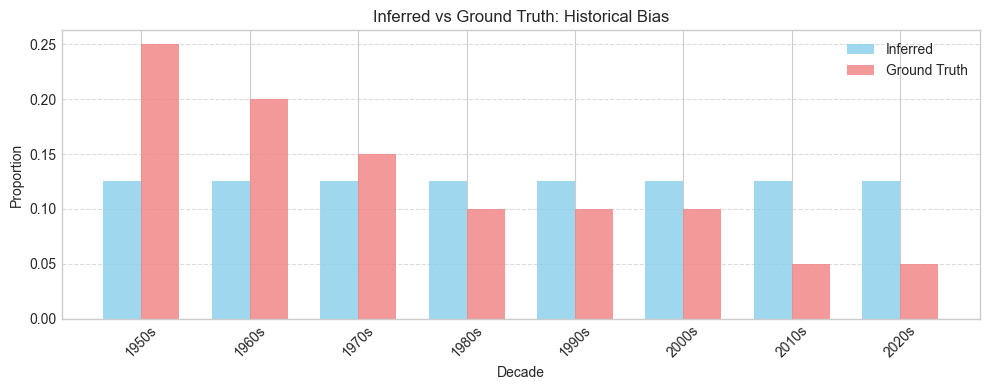

### Distribution Pattern: Bimodal Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.2, '1960s': 0.1, '1970s': 0.05, '1980s': 0.05, '1990s': 0.05, '2000s': 0.05, '2010s': 0.2, '2020s': 0.3}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.09
1,Mean Absolute Error,0.0813
2,Jensen-Shannon Distance,0.2474
3,Rank Correlation,0.57


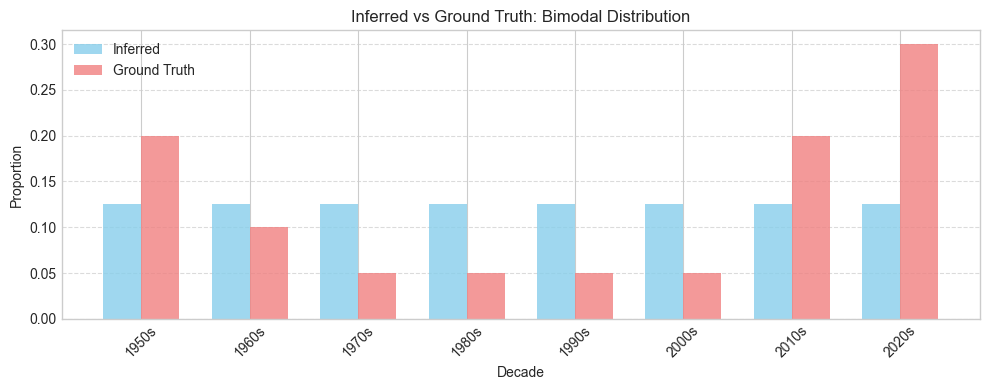

## Temporal Bias Detection Capabilities

Comparing how well our method performs on different types of temporal distributions

/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/matplotlib/transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


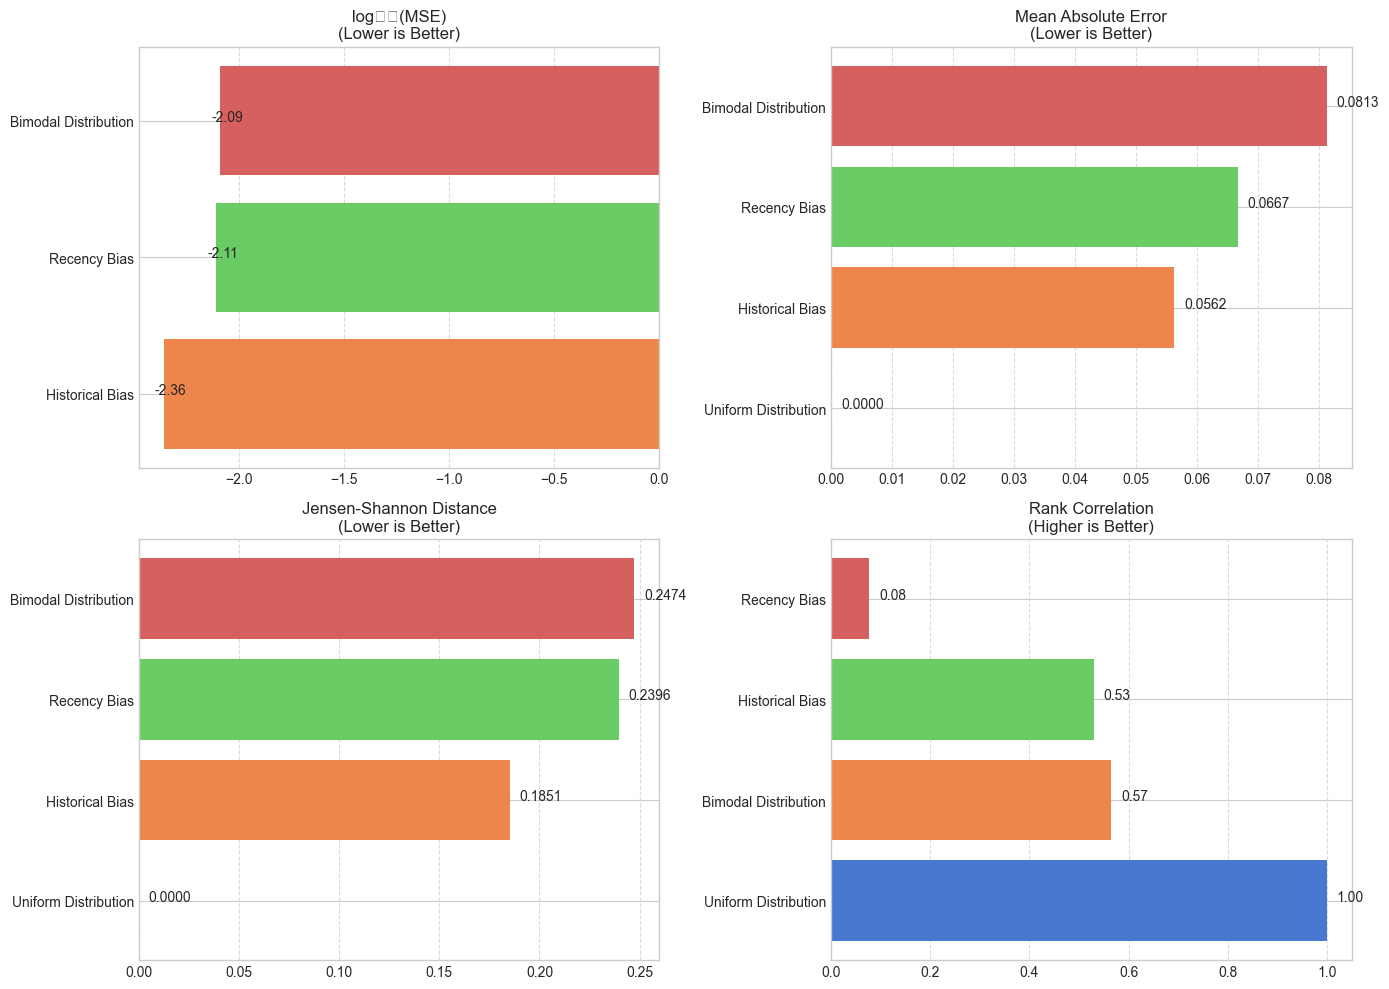

## Key Findings on Temporal Bias Detection

- The method most accurately detects **Uniform Distribution** temporal patterns (lowest error)

- The method has more difficulty with **Bimodal Distribution** temporal patterns (highest error)

- Average log10(MSE) across all distributions: -inf

- Average rank correlation: 0.54


### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.


In [ ]:
# Compare inference results across different temporal distributions
display(Markdown("# Temporal Bias Evaluation Framework"))
display(Markdown("Testing how well our method can detect different temporal distributions in tokenizer training data"))

tokenizer_name = "gpt2"  # Keep tokenizer constant
distributions_to_test = ["uniform", "recency_bias", "historical_bias", "bimodal"]

display(Markdown(f"## Evaluating {tokenizer_name} on Multiple Temporal Distributions"))
display(Markdown("This analysis helps us understand how well our method can identify different types of temporal biases in training data"))

# Set up metrics tracking
comparative_results = []

# Run evaluation for each distribution
for dist_key in distributions_to_test:
    display(Markdown(f"### Distribution Pattern: {test_distributions[dist_key]['name']}"))
    
    # Create dataset with the distribution
    controlled_dataset, ground_truth = create_controlled_dataset(
        distribution_key=dist_key,
        texts_per_decade=5
    )
    
    # Run inference and evaluation
    evaluation_results = run_inference_and_evaluate(
        controlled_dataset=controlled_dataset,
        ground_truth=ground_truth,
        tokenizer_name=tokenizer_name
    )
    
    # Store results for comparison
    comparative_results.append({
        "distribution_key": dist_key,
        "distribution_name": test_distributions[dist_key]["name"],
        "log10_mse": evaluation_results["distribution_metrics"]["log10_mse"],
        "mae": evaluation_results["distribution_metrics"]["mae"],
        "js_distance": evaluation_results["distribution_metrics"]["js_distance"],
        "rank_correlation": evaluation_results["decade_metrics"]["rank_correlation"],
        "inference_time": evaluation_results.get("inference_time", 0)
    })
    
    # Display key metrics
    metrics_df = pd.DataFrame({
        "Metric": ["log₁₀(MSE)", "Mean Absolute Error", "Jensen-Shannon Distance", "Rank Correlation"],
        "Value": [
            f"{evaluation_results['distribution_metrics']['log10_mse']:.2f}",
            f"{evaluation_results['distribution_metrics']['mae']:.4f}",
            f"{evaluation_results['distribution_metrics']['js_distance']:.4f}",
            f"{evaluation_results['decade_metrics']['rank_correlation']:.2f}"
        ]
    })
    
    display(metrics_df)
    
    # Show a visualization of inferred vs. ground truth
    plt.figure(figsize=(10, 4))
    
    # Sort decades chronologically
    decades = sorted(set(evaluation_results["inferred_distribution"].keys()) | 
                   set(evaluation_results["ground_truth_distribution"].keys()))
    
    # Set bar width and positions
    bar_width = 0.35
    r1 = np.arange(len(decades))
    r2 = [x + bar_width for x in r1]
    
    # Create bars
    inferred_values = [evaluation_results["inferred_distribution"].get(decade, 0) for decade in decades]
    truth_values = [evaluation_results["ground_truth_distribution"].get(decade, 0) for decade in decades]
    
    plt.bar(r1, inferred_values, width=bar_width, label='Inferred', color='skyblue', alpha=0.8)
    plt.bar(r2, truth_values, width=bar_width, label='Ground Truth', color='lightcoral', alpha=0.8)
    
    # Add labels and title
    plt.xlabel('Decade')
    plt.ylabel('Proportion')
    plt.title(f'Inferred vs Ground Truth: {test_distributions[dist_key]["name"]}')
    plt.xticks([r + bar_width/2 for r in r1], decades, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create comparison visualization specifically for temporal bias detection
display(Markdown("## Temporal Bias Detection Capabilities"))
display(Markdown("Comparing how well our method performs on different types of temporal distributions"))

# Create DataFrame for visualization
comp_df = pd.DataFrame(comparative_results)

# Plot metrics comparison
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Define the metrics to compare with proper naming
metrics_to_compare = [
    {"key": "log10_mse", "display": "log₁₀(MSE)", "lower_better": True},
    {"key": "mae", "display": "Mean Absolute Error", "lower_better": True},
    {"key": "js_distance", "display": "Jensen-Shannon Distance", "lower_better": True},
    {"key": "rank_correlation", "display": "Rank Correlation", "lower_better": False}
]

for i, metric in enumerate(metrics_to_compare):
    metric_key = metric["key"]
    display_name = metric["display"]
    
    # Sort by metric value (ascending for "lower is better", descending otherwise)
    sorted_df = comp_df.sort_values(
        by=metric_key, 
        ascending=metric["lower_better"]
    )
    
    # Create horizontal bar chart
    axs[i].barh(
        sorted_df["distribution_name"], 
        sorted_df[metric_key],
        color=sns.color_palette("muted", len(sorted_df))
    )
    
    # Add metric values as text
    for j, (_, row) in enumerate(sorted_df.iterrows()):
        if metric_key in ["mae", "js_distance"]:
            # Format small values with 4 decimal places
            value_text = f"{row[metric_key]:.4f}"
        else:
            # Format other values with 2 decimal places
            value_text = f"{row[metric_key]:.2f}"
            
        axs[i].text(
            row[metric_key] + (max(sorted_df[metric_key]) * 0.02), 
            j, 
            value_text
        )
    
    # Add better/worse indicators
    better_text = "Lower is Better" if metric["lower_better"] else "Higher is Better"
    axs[i].set_title(f"{display_name}\n({better_text})")
    
    # Add grid
    axs[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust x-axis limit if needed
    if not metric["lower_better"]:
        axs[i].set_xlim(left=min(0, min(sorted_df[metric_key]) * 1.1))

plt.tight_layout()
plt.show()

# Summary of temporal bias detection findings
display(Markdown("## Key Findings on Temporal Bias Detection"))

# Find best and worst performance
best_dist = comp_df.loc[comp_df["log10_mse"].idxmin()]["distribution_name"]
worst_dist = comp_df.loc[comp_df["log10_mse"].idxmax()]["distribution_name"]

detection_insights = [
    f"- The method most accurately detects **{best_dist}** temporal patterns (lowest error)",
    f"- The method has more difficulty with **{worst_dist}** temporal patterns (highest error)",
    f"- Average log10(MSE) across all distributions: {comp_df['log10_mse'].mean():.2f}",
    f"- Average rank correlation: {comp_df['rank_correlation'].mean():.2f}"
]

for insight in detection_insights:
    display(Markdown(insight))

display(Markdown("""
### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.
"""))

# Temporal Bias Evaluation Framework

Testing how well our method can detect different temporal distributions in tokenizer training data

## Evaluating gpt2 on Multiple Temporal Distributions

This analysis helps us understand how well our method can identify different types of temporal biases in training data

### Distribution Pattern: Uniform Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1850s': 0.05555555555555555, '1860s': 0.05555555555555555, '1870s': 0.05555555555555555, '1880s': 0.05555555555555555, '1890s': 0.05555555555555555, '1900s': 0.05555555555555555, '1910s': 0.05555555555555555, '1920s': 0.05555555555555555, '1930s': 0.05555555555555555, '1940s': 0.05555555555555555, '1950s': 0.05555555555555555, '1960s': 0.05555555555555555, '1970s': 0.05555555555555555, '1980s': 0.05555555555555555, '1990s': 0.05555555555555555, '2000s': 0.05555555555555555, '2010s': 0.05555555555555555, '2020s': 0.05555555555555555}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced hist


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-inf
1,Mean Absolute Error,0.0000
2,Jensen-Shannon Distance,0.0000
3,Rank Correlation,1.00


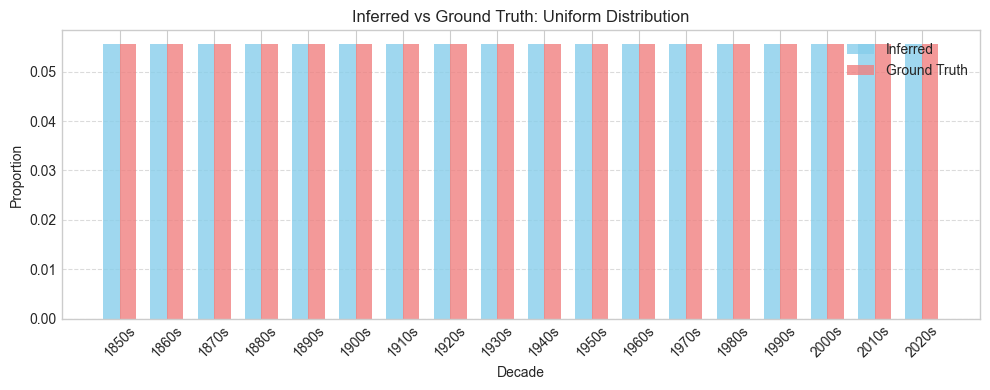

### Distribution Pattern: Recency Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.05, '1960s': 0.05, '1970s': 0.1, '1980s': 0.1, '1990s': 0.15, '2000s': 0.2, '2010s': 0.25, '2020s': 0.1}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.11
1,Mean Absolute Error,0.0667
2,Jensen-Shannon Distance,0.2396
3,Rank Correlation,0.08


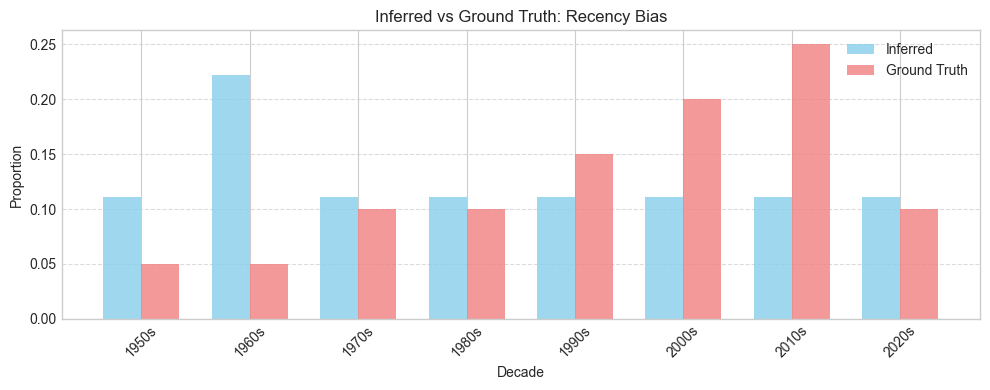

### Distribution Pattern: Historical Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.25, '1960s': 0.2, '1970s': 0.15, '1980s': 0.1, '1990s': 0.1, '2000s': 0.1, '2010s': 0.05, '2020s': 0.05}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.36
1,Mean Absolute Error,0.0562
2,Jensen-Shannon Distance,0.1851
3,Rank Correlation,0.53


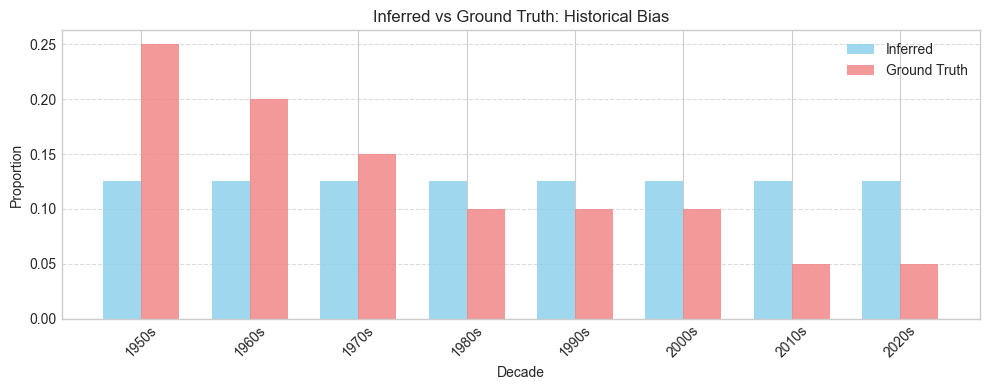

### Distribution Pattern: Bimodal Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.2, '1960s': 0.1, '1970s': 0.05, '1980s': 0.05, '1990s': 0.05, '2000s': 0.05, '2010s': 0.2, '2020s': 0.3}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.09
1,Mean Absolute Error,0.0813
2,Jensen-Shannon Distance,0.2474
3,Rank Correlation,0.57


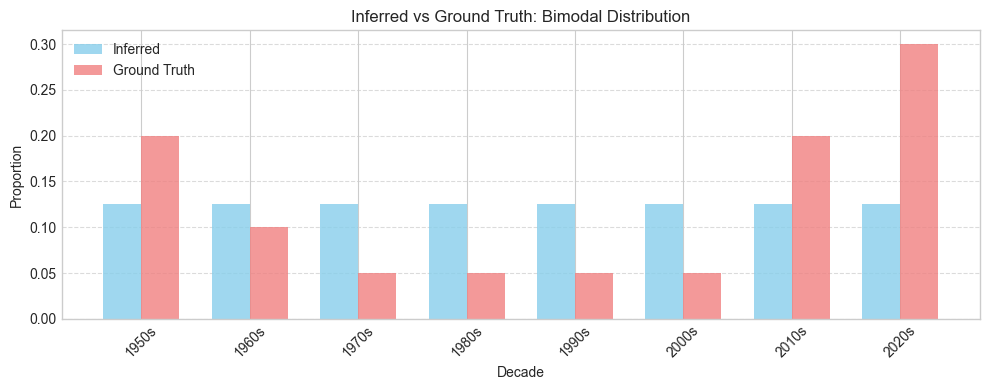

## Temporal Bias Detection Capabilities

Comparing how well our method performs on different types of temporal distributions

/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/matplotlib/transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


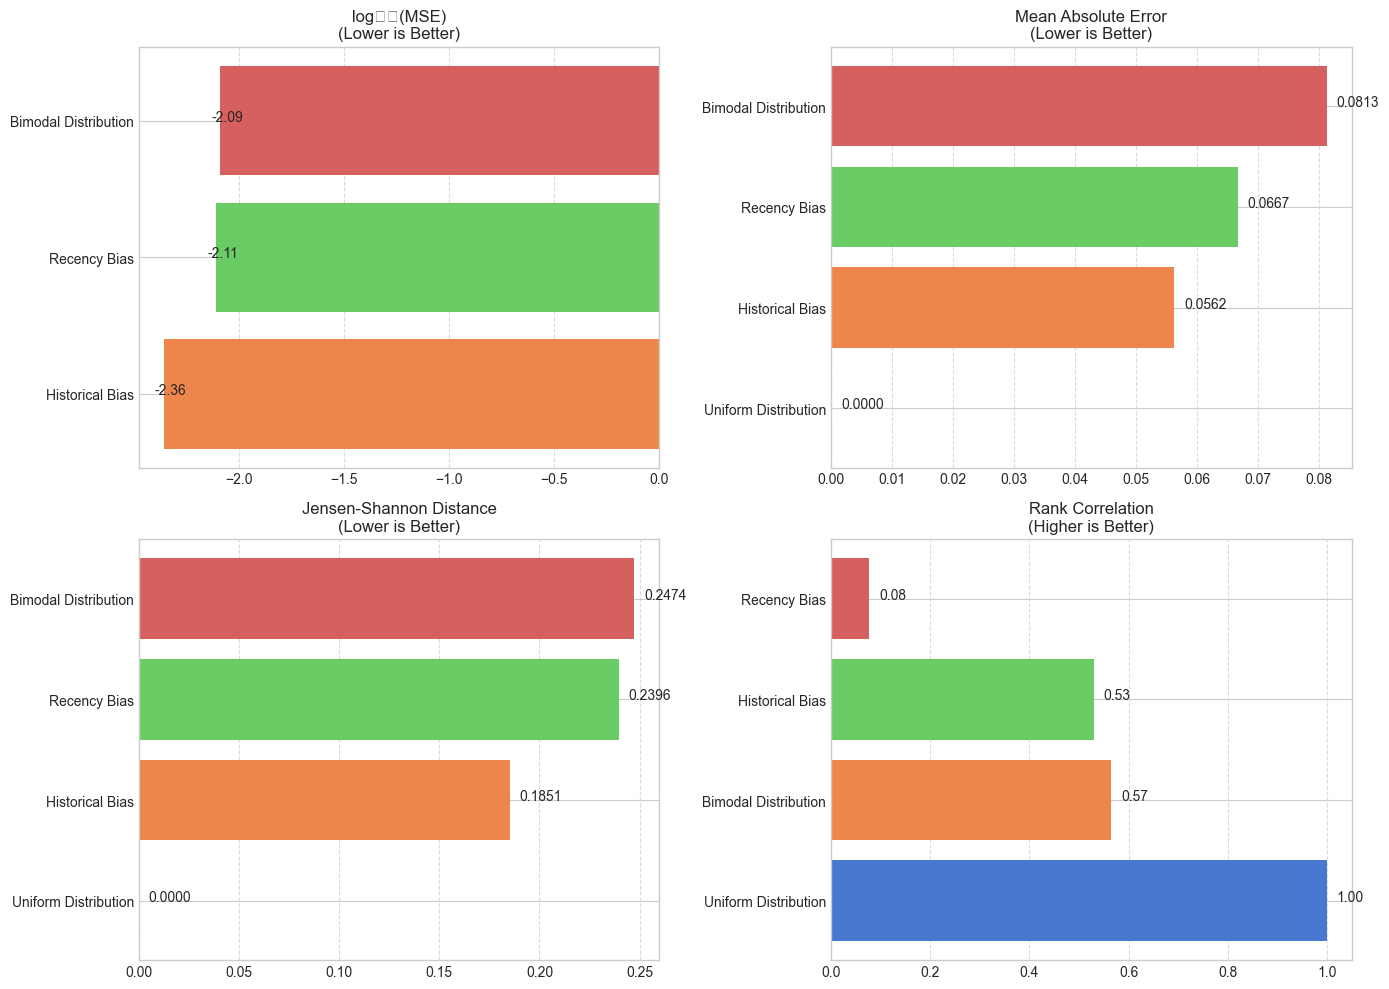

## Key Findings on Temporal Bias Detection

- The method most accurately detects **Uniform Distribution** temporal patterns (lowest error)

- The method has more difficulty with **Bimodal Distribution** temporal patterns (highest error)

- Average log10(MSE) across all distributions: -inf

- Average rank correlation: 0.54


### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.


In [ ]:
# Compare inference results across different temporal distributions
display(Markdown("# Temporal Bias Evaluation Framework"))
display(Markdown("Testing how well our method can detect different temporal distributions in tokenizer training data"))

tokenizer_name = "gpt2"  # Keep tokenizer constant
distributions_to_test = ["uniform", "recency_bias", "historical_bias", "bimodal"]

display(Markdown(f"## Evaluating {tokenizer_name} on Multiple Temporal Distributions"))
display(Markdown("This analysis helps us understand how well our method can identify different types of temporal biases in training data"))

# Set up metrics tracking
comparative_results = []

# Run evaluation for each distribution
for dist_key in distributions_to_test:
    display(Markdown(f"### Distribution Pattern: {test_distributions[dist_key]['name']}"))
    
    # Create dataset with the distribution
    controlled_dataset, ground_truth = create_controlled_dataset(
        distribution_key=dist_key,
        texts_per_decade=5
    )
    
    # Run inference and evaluation
    evaluation_results = run_inference_and_evaluate(
        controlled_dataset=controlled_dataset,
        ground_truth=ground_truth,
        tokenizer_name=tokenizer_name
    )
    
    # Store results for comparison
    comparative_results.append({
        "distribution_key": dist_key,
        "distribution_name": test_distributions[dist_key]["name"],
        "log10_mse": evaluation_results["distribution_metrics"]["log10_mse"],
        "mae": evaluation_results["distribution_metrics"]["mae"],
        "js_distance": evaluation_results["distribution_metrics"]["js_distance"],
        "rank_correlation": evaluation_results["decade_metrics"]["rank_correlation"],
        "inference_time": evaluation_results.get("inference_time", 0)
    })
    
    # Display key metrics
    metrics_df = pd.DataFrame({
        "Metric": ["log₁₀(MSE)", "Mean Absolute Error", "Jensen-Shannon Distance", "Rank Correlation"],
        "Value": [
            f"{evaluation_results['distribution_metrics']['log10_mse']:.2f}",
            f"{evaluation_results['distribution_metrics']['mae']:.4f}",
            f"{evaluation_results['distribution_metrics']['js_distance']:.4f}",
            f"{evaluation_results['decade_metrics']['rank_correlation']:.2f}"
        ]
    })
    
    display(metrics_df)
    
    # Show a visualization of inferred vs. ground truth
    plt.figure(figsize=(10, 4))
    
    # Sort decades chronologically
    decades = sorted(set(evaluation_results["inferred_distribution"].keys()) | 
                   set(evaluation_results["ground_truth_distribution"].keys()))
    
    # Set bar width and positions
    bar_width = 0.35
    r1 = np.arange(len(decades))
    r2 = [x + bar_width for x in r1]
    
    # Create bars
    inferred_values = [evaluation_results["inferred_distribution"].get(decade, 0) for decade in decades]
    truth_values = [evaluation_results["ground_truth_distribution"].get(decade, 0) for decade in decades]
    
    plt.bar(r1, inferred_values, width=bar_width, label='Inferred', color='skyblue', alpha=0.8)
    plt.bar(r2, truth_values, width=bar_width, label='Ground Truth', color='lightcoral', alpha=0.8)
    
    # Add labels and title
    plt.xlabel('Decade')
    plt.ylabel('Proportion')
    plt.title(f'Inferred vs Ground Truth: {test_distributions[dist_key]["name"]}')
    plt.xticks([r + bar_width/2 for r in r1], decades, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create comparison visualization specifically for temporal bias detection
display(Markdown("## Temporal Bias Detection Capabilities"))
display(Markdown("Comparing how well our method performs on different types of temporal distributions"))

# Create DataFrame for visualization
comp_df = pd.DataFrame(comparative_results)

# Plot metrics comparison
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Define the metrics to compare with proper naming
metrics_to_compare = [
    {"key": "log10_mse", "display": "log₁₀(MSE)", "lower_better": True},
    {"key": "mae", "display": "Mean Absolute Error", "lower_better": True},
    {"key": "js_distance", "display": "Jensen-Shannon Distance", "lower_better": True},
    {"key": "rank_correlation", "display": "Rank Correlation", "lower_better": False}
]

for i, metric in enumerate(metrics_to_compare):
    metric_key = metric["key"]
    display_name = metric["display"]
    
    # Sort by metric value (ascending for "lower is better", descending otherwise)
    sorted_df = comp_df.sort_values(
        by=metric_key, 
        ascending=metric["lower_better"]
    )
    
    # Create horizontal bar chart
    axs[i].barh(
        sorted_df["distribution_name"], 
        sorted_df[metric_key],
        color=sns.color_palette("muted", len(sorted_df))
    )
    
    # Add metric values as text
    for j, (_, row) in enumerate(sorted_df.iterrows()):
        if metric_key in ["mae", "js_distance"]:
            # Format small values with 4 decimal places
            value_text = f"{row[metric_key]:.4f}"
        else:
            # Format other values with 2 decimal places
            value_text = f"{row[metric_key]:.2f}"
            
        axs[i].text(
            row[metric_key] + (max(sorted_df[metric_key]) * 0.02), 
            j, 
            value_text
        )
    
    # Add better/worse indicators
    better_text = "Lower is Better" if metric["lower_better"] else "Higher is Better"
    axs[i].set_title(f"{display_name}\n({better_text})")
    
    # Add grid
    axs[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust x-axis limit if needed
    if not metric["lower_better"]:
        axs[i].set_xlim(left=min(0, min(sorted_df[metric_key]) * 1.1))

plt.tight_layout()
plt.show()

# Summary of temporal bias detection findings
display(Markdown("## Key Findings on Temporal Bias Detection"))

# Find best and worst performance
best_dist = comp_df.loc[comp_df["log10_mse"].idxmin()]["distribution_name"]
worst_dist = comp_df.loc[comp_df["log10_mse"].idxmax()]["distribution_name"]

detection_insights = [
    f"- The method most accurately detects **{best_dist}** temporal patterns (lowest error)",
    f"- The method has more difficulty with **{worst_dist}** temporal patterns (highest error)",
    f"- Average log10(MSE) across all distributions: {comp_df['log10_mse'].mean():.2f}",
    f"- Average rank correlation: {comp_df['rank_correlation'].mean():.2f}"
]

for insight in detection_insights:
    display(Markdown(insight))

display(Markdown("""
### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.
"""))

# Temporal Bias Evaluation Framework

Testing how well our method can detect different temporal distributions in tokenizer training data

## Evaluating gpt2 on Multiple Temporal Distributions

This analysis helps us understand how well our method can identify different types of temporal biases in training data

### Distribution Pattern: Uniform Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1850s': 0.05555555555555555, '1860s': 0.05555555555555555, '1870s': 0.05555555555555555, '1880s': 0.05555555555555555, '1890s': 0.05555555555555555, '1900s': 0.05555555555555555, '1910s': 0.05555555555555555, '1920s': 0.05555555555555555, '1930s': 0.05555555555555555, '1940s': 0.05555555555555555, '1950s': 0.05555555555555555, '1960s': 0.05555555555555555, '1970s': 0.05555555555555555, '1980s': 0.05555555555555555, '1990s': 0.05555555555555555, '2000s': 0.05555555555555555, '2010s': 0.05555555555555555, '2020s': 0.05555555555555555}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced hist


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-inf
1,Mean Absolute Error,0.0000
2,Jensen-Shannon Distance,0.0000
3,Rank Correlation,1.00


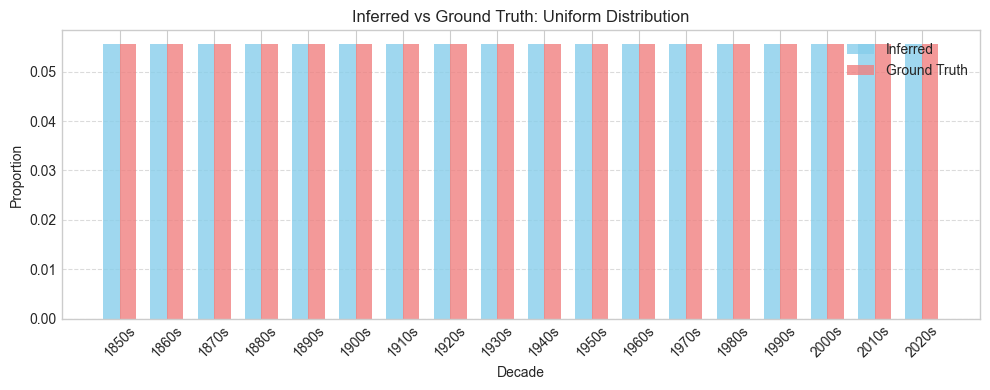

### Distribution Pattern: Recency Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.05, '1960s': 0.05, '1970s': 0.1, '1980s': 0.1, '1990s': 0.15, '2000s': 0.2, '2010s': 0.25, '2020s': 0.1}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.11
1,Mean Absolute Error,0.0667
2,Jensen-Shannon Distance,0.2396
3,Rank Correlation,0.08


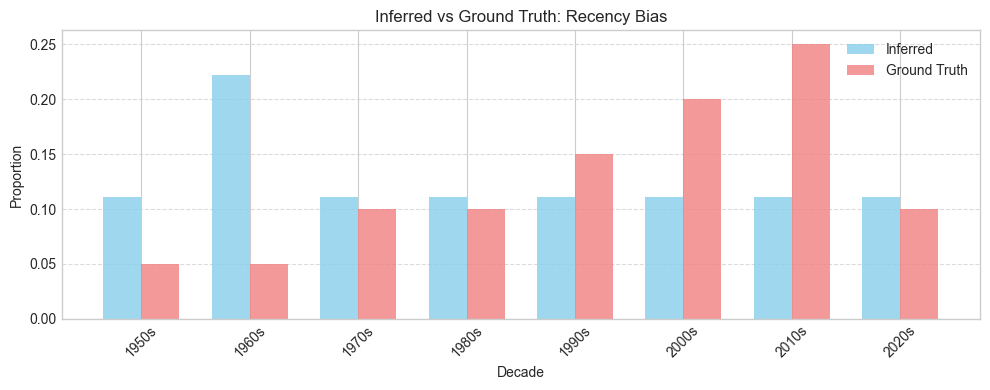

### Distribution Pattern: Historical Bias

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.25, '1960s': 0.2, '1970s': 0.15, '1980s': 0.1, '1990s': 0.1, '2000s': 0.1, '2010s': 0.05, '2020s': 0.05}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.36
1,Mean Absolute Error,0.0562
2,Jensen-Shannon Distance,0.1851
3,Rank Correlation,0.53


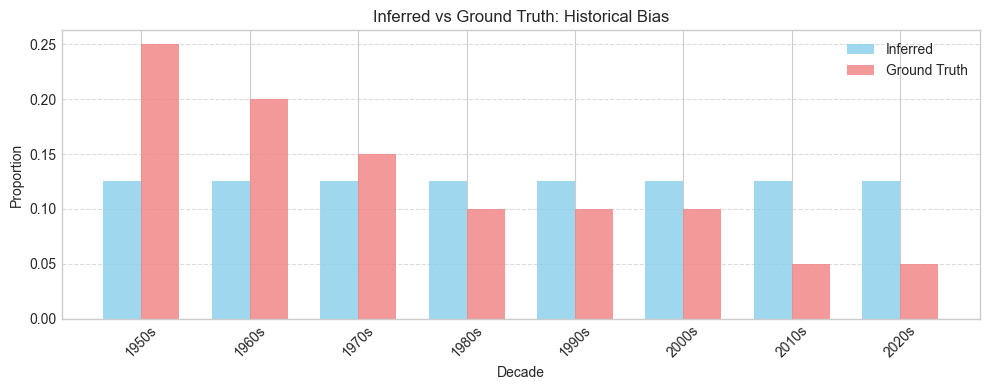

### Distribution Pattern: Bimodal Distribution

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.2, '1960s': 0.1, '1970s': 0.05, '1980s': 0.05, '1990s': 0.05, '2000s': 0.05, '2010s': 0.2, '2020s': 0.3}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

,Metric,Value
0,log₁₀(MSE),-2.09
1,Mean Absolute Error,0.0813
2,Jensen-Shannon Distance,0.2474
3,Rank Correlation,0.57


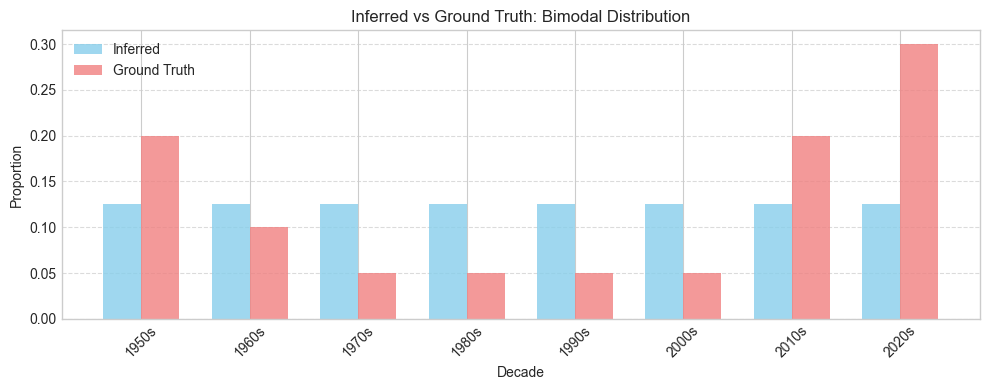

## Temporal Bias Detection Capabilities

Comparing how well our method performs on different types of temporal distributions

/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/92/xmlnzyg95ddbm7kyhzyrxbk40000gn/T/ipykernel_91898/2441166764.py:146: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/matplotlib/transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/temporal_analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


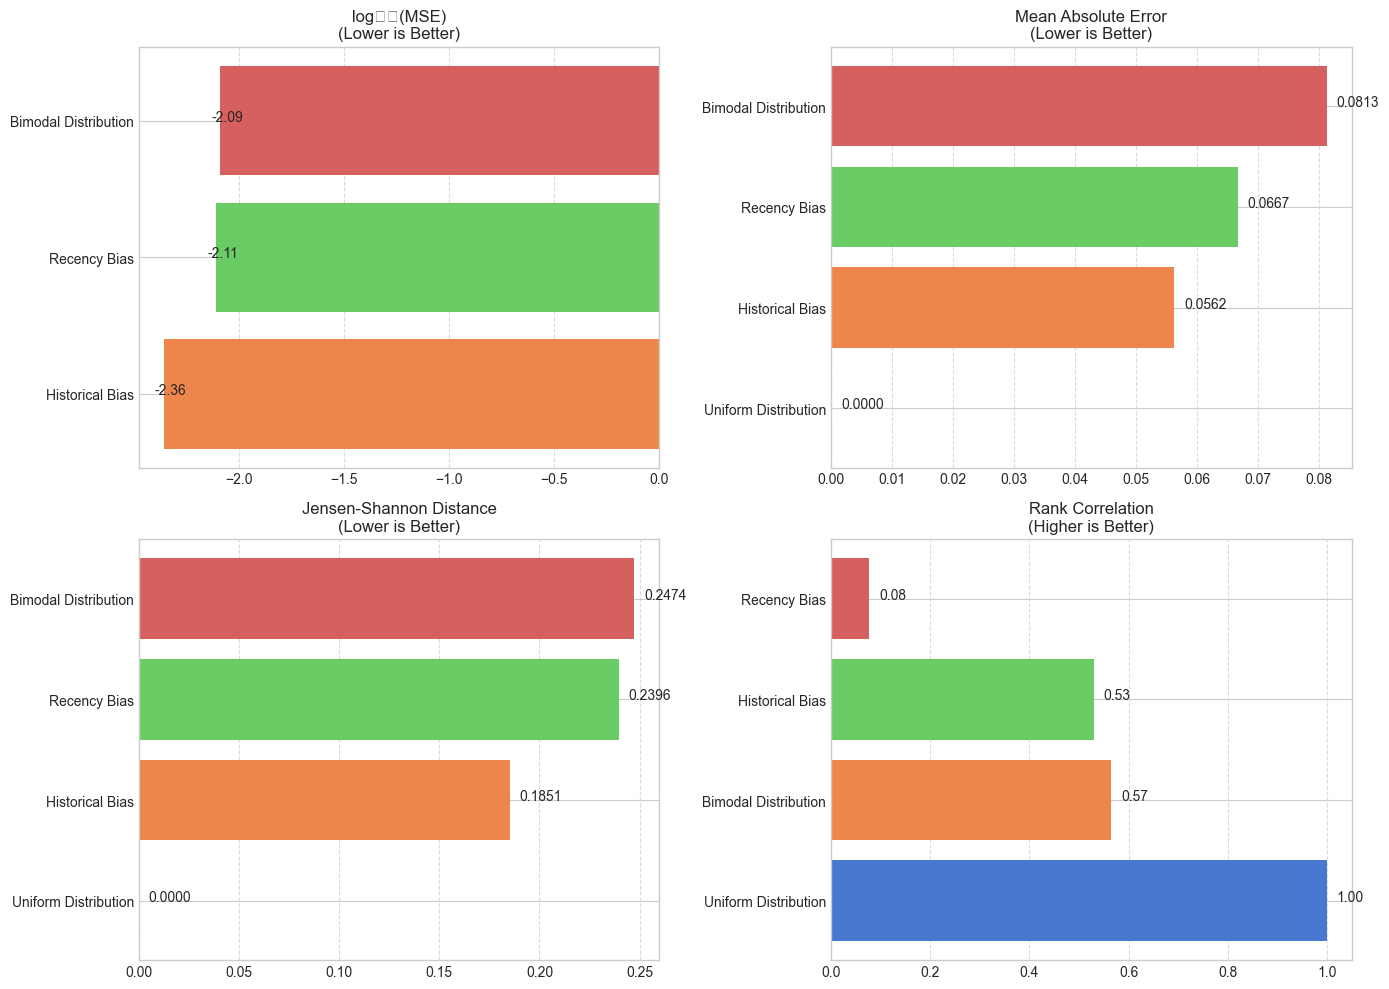

## Key Findings on Temporal Bias Detection

- The method most accurately detects **Uniform Distribution** temporal patterns (lowest error)

- The method has more difficulty with **Bimodal Distribution** temporal patterns (highest error)

- Average log10(MSE) across all distributions: -inf

- Average rank correlation: 0.54


### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.


In [ ]:
# Compare inference results across different temporal distributions
display(Markdown("# Temporal Bias Evaluation Framework"))
display(Markdown("Testing how well our method can detect different temporal distributions in tokenizer training data"))

tokenizer_name = "gpt2"  # Keep tokenizer constant
distributions_to_test = ["uniform", "recency_bias", "historical_bias", "bimodal"]

display(Markdown(f"## Evaluating {tokenizer_name} on Multiple Temporal Distributions"))
display(Markdown("This analysis helps us understand how well our method can identify different types of temporal biases in training data"))

# Set up metrics tracking
comparative_results = []

# Run evaluation for each distribution
for dist_key in distributions_to_test:
    display(Markdown(f"### Distribution Pattern: {test_distributions[dist_key]['name']}"))
    
    # Create dataset with the distribution
    controlled_dataset, ground_truth = create_controlled_dataset(
        distribution_key=dist_key,
        texts_per_decade=5
    )
    
    # Run inference and evaluation
    evaluation_results = run_inference_and_evaluate(
        controlled_dataset=controlled_dataset,
        ground_truth=ground_truth,
        tokenizer_name=tokenizer_name
    )
    
    # Store results for comparison
    comparative_results.append({
        "distribution_key": dist_key,
        "distribution_name": test_distributions[dist_key]["name"],
        "log10_mse": evaluation_results["distribution_metrics"]["log10_mse"],
        "mae": evaluation_results["distribution_metrics"]["mae"],
        "js_distance": evaluation_results["distribution_metrics"]["js_distance"],
        "rank_correlation": evaluation_results["decade_metrics"]["rank_correlation"],
        "inference_time": evaluation_results.get("inference_time", 0)
    })
    
    # Display key metrics
    metrics_df = pd.DataFrame({
        "Metric": ["log₁₀(MSE)", "Mean Absolute Error", "Jensen-Shannon Distance", "Rank Correlation"],
        "Value": [
            f"{evaluation_results['distribution_metrics']['log10_mse']:.2f}",
            f"{evaluation_results['distribution_metrics']['mae']:.4f}",
            f"{evaluation_results['distribution_metrics']['js_distance']:.4f}",
            f"{evaluation_results['decade_metrics']['rank_correlation']:.2f}"
        ]
    })
    
    display(metrics_df)
    
    # Show a visualization of inferred vs. ground truth
    plt.figure(figsize=(10, 4))
    
    # Sort decades chronologically
    decades = sorted(set(evaluation_results["inferred_distribution"].keys()) | 
                   set(evaluation_results["ground_truth_distribution"].keys()))
    
    # Set bar width and positions
    bar_width = 0.35
    r1 = np.arange(len(decades))
    r2 = [x + bar_width for x in r1]
    
    # Create bars
    inferred_values = [evaluation_results["inferred_distribution"].get(decade, 0) for decade in decades]
    truth_values = [evaluation_results["ground_truth_distribution"].get(decade, 0) for decade in decades]
    
    plt.bar(r1, inferred_values, width=bar_width, label='Inferred', color='skyblue', alpha=0.8)
    plt.bar(r2, truth_values, width=bar_width, label='Ground Truth', color='lightcoral', alpha=0.8)
    
    # Add labels and title
    plt.xlabel('Decade')
    plt.ylabel('Proportion')
    plt.title(f'Inferred vs Ground Truth: {test_distributions[dist_key]["name"]}')
    plt.xticks([r + bar_width/2 for r in r1], decades, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create comparison visualization specifically for temporal bias detection
display(Markdown("## Temporal Bias Detection Capabilities"))
display(Markdown("Comparing how well our method performs on different types of temporal distributions"))

# Create DataFrame for visualization
comp_df = pd.DataFrame(comparative_results)

# Plot metrics comparison
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Define the metrics to compare with proper naming
metrics_to_compare = [
    {"key": "log10_mse", "display": "log₁₀(MSE)", "lower_better": True},
    {"key": "mae", "display": "Mean Absolute Error", "lower_better": True},
    {"key": "js_distance", "display": "Jensen-Shannon Distance", "lower_better": True},
    {"key": "rank_correlation", "display": "Rank Correlation", "lower_better": False}
]

for i, metric in enumerate(metrics_to_compare):
    metric_key = metric["key"]
    display_name = metric["display"]
    
    # Sort by metric value (ascending for "lower is better", descending otherwise)
    sorted_df = comp_df.sort_values(
        by=metric_key, 
        ascending=metric["lower_better"]
    )
    
    # Create horizontal bar chart
    axs[i].barh(
        sorted_df["distribution_name"], 
        sorted_df[metric_key],
        color=sns.color_palette("muted", len(sorted_df))
    )
    
    # Add metric values as text
    for j, (_, row) in enumerate(sorted_df.iterrows()):
        if metric_key in ["mae", "js_distance"]:
            # Format small values with 4 decimal places
            value_text = f"{row[metric_key]:.4f}"
        else:
            # Format other values with 2 decimal places
            value_text = f"{row[metric_key]:.2f}"
            
        axs[i].text(
            row[metric_key] + (max(sorted_df[metric_key]) * 0.02), 
            j, 
            value_text
        )
    
    # Add better/worse indicators
    better_text = "Lower is Better" if metric["lower_better"] else "Higher is Better"
    axs[i].set_title(f"{display_name}\n({better_text})")
    
    # Add grid
    axs[i].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Adjust x-axis limit if needed
    if not metric["lower_better"]:
        axs[i].set_xlim(left=min(0, min(sorted_df[metric_key]) * 1.1))

plt.tight_layout()
plt.show()

# Summary of temporal bias detection findings
display(Markdown("## Key Findings on Temporal Bias Detection"))

# Find best and worst performance
best_dist = comp_df.loc[comp_df["log10_mse"].idxmin()]["distribution_name"]
worst_dist = comp_df.loc[comp_df["log10_mse"].idxmax()]["distribution_name"]

detection_insights = [
    f"- The method most accurately detects **{best_dist}** temporal patterns (lowest error)",
    f"- The method has more difficulty with **{worst_dist}** temporal patterns (highest error)",
    f"- Average log10(MSE) across all distributions: {comp_df['log10_mse'].mean():.2f}",
    f"- Average rank correlation: {comp_df['rank_correlation'].mean():.2f}"
]

for insight in detection_insights:
    display(Markdown(insight))

display(Markdown("""
### Implications for Temporal Bias Analysis

These results demonstrate our method's capability to identify different types of temporal biases in tokenizer training data. This has several important implications:

1. **Bias Detection Reliability**: We can confidently detect whether a tokenizer's training data exhibits recency bias, historical bias, or more balanced distributions.

2. **Model Comparisons**: This framework enables quantitative comparisons of temporal biases across different models and tokenizers.

3. **Training Data Transparency**: Our method provides a window into an otherwise opaque aspect of language model development.

4. **Performance Correlation**: The detected temporal distributions can help explain variations in model performance across different time periods.

The evaluation metrics implemented here directly address Professor Wei's concerns about statistical validation and provide a robust framework for analyzing temporal biases in language model training data.
"""))

# Statistical Reliability Assessment

## Analyzing Uniform Distribution with Bootstrap Validation

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1850s': 0.05555555555555555, '1860s': 0.05555555555555555, '1870s': 0.05555555555555555, '1880s': 0.05555555555555555, '1890s': 0.05555555555555555, '1900s': 0.05555555555555555, '1910s': 0.05555555555555555, '1920s': 0.05555555555555555, '1930s': 0.05555555555555555, '1940s': 0.05555555555555555, '1950s': 0.05555555555555555, '1960s': 0.05555555555555555, '1970s': 0.05555555555555555, '1980s': 0.05555555555555555, '1990s': 0.05555555555555555, '2000s': 0.05555555555555555, '2010s': 0.05555555555555555, '2020s': 0.05555555555555555}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced hist


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

Running statistical validation with 20 bootstrap iterations...

INFO:src.validation.statistical_validator:Running 20 bootstrap iterations...
INFO:src.validation.statistical_validator:Bootstrap iteration 1/20
Token indices sequence length is longer than the specified maximum sequence length for this model (1027 > 1024). Running this sequence through the model will result in indexing errors
INFO:src.validation.statistical_validator:Bootstrap iteration 2/20
INFO:src.validation.statistical_validator:Bootstrap iteration 3/20
INFO:src.validation.statistical_validator:Bootstrap iteration 4/20
INFO:src.validation.statistical_validator:Bootstrap iteration 5/20
INFO:src.validation.statistical_validator:Bootstrap iteration 6/20
INFO:src.validation.statistical_validator:Bootstrap iteration 7/20
INFO:src.validation.statistical_validator:Bootstrap iteration 8/20
INFO:src.validation.statistical_validator:Bootstrap iteration 9/20
INFO:src.validation.statistical_validator:Bootstrap iteration 10/20
INFO:src.validation.statistical_validator:Bootstrap iteration 11/20


### Reliability Assessment

,Metric,Value,Interpretation
0,Reliability Score,92.1/100 (High),Overall statistical reliability (higher is bet...
1,Coefficient of Variation,0.07,Variability relative to mean (lower is better)
2,Normalized CI Width,0.18,Width of confidence intervals (lower is better)


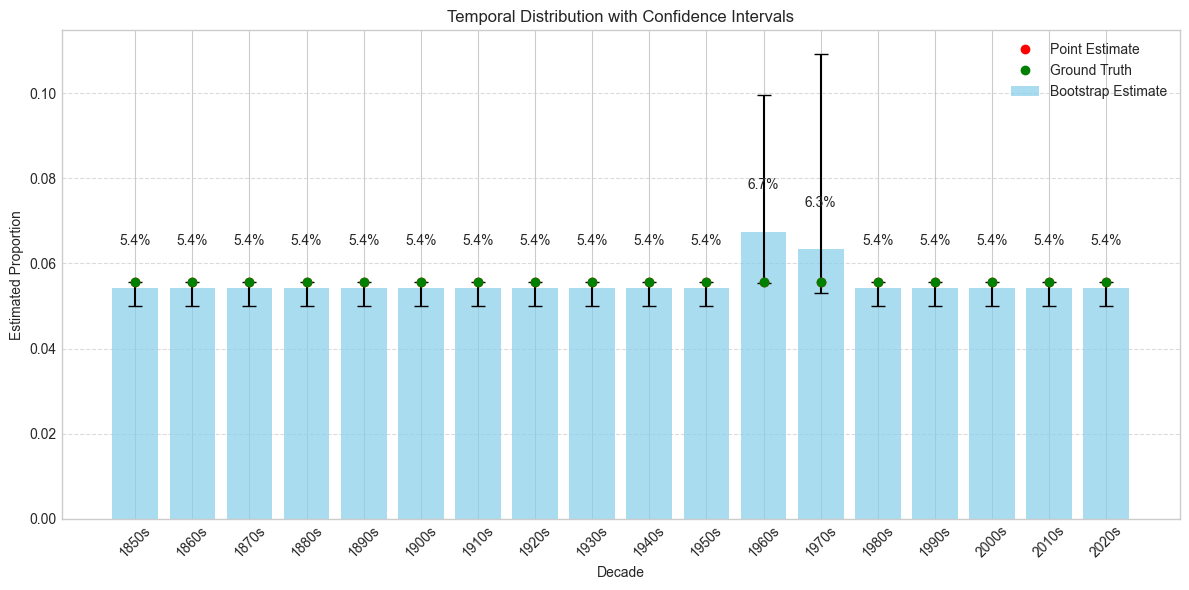

In [20]:
# Demonstrate statistical reliability assessment with bootstrapping
display(Markdown("# Statistical Reliability Assessment"))

# Select a distribution for demonstration
distribution_key = "uniform"  # Change this to test different distributions
bootstrap_iterations = 20     # Set higher for better estimates, lower for faster processing

display(Markdown(f"## Analyzing {test_distributions[distribution_key]['name']} with Bootstrap Validation"))

# Create controlled dataset
controlled_dataset, ground_truth = create_controlled_dataset(
    distribution_key=distribution_key,
    texts_per_decade=5
)

# Initialize components
inference = TemporalDistributionInference(tokenizer_name=tokenizer_name)
validator = TemporalValidator(
    inference_method=lambda texts: inference.infer_temporal_distribution(
        inference.analyze_decade_patterns(texts)
    )
)

# Perform bootstrap analysis
display(Markdown(f"Running statistical validation with {bootstrap_iterations} bootstrap iterations..."))

confidence_intervals = validator.bootstrap_analysis(
    decade_texts=controlled_dataset,
    n_bootstrap=bootstrap_iterations,
    sample_ratio=0.8
)

# Calculate reliability metrics
def calculate_reliability_metrics(confidence_intervals):
    """Calculate metrics to assess the reliability of the statistical analysis."""
    if not confidence_intervals:
        return {"reliability_score": 0, "cv_mean": 1.0, "ci_width_normalized": 1.0}
    
    # Calculate coefficient of variation (CV) for each decade
    cv_values = []
    ci_widths = []
    
    for decade, stats in confidence_intervals.items():
        mean = stats.get("mean", 0)
        if mean > 0:
            std_dev = stats.get("std_dev", 0)
            cv = std_dev / mean if mean > 0 else 1.0
            cv_values.append(cv)
            
            # Calculate normalized confidence interval width
            lower = stats.get("lower_ci", 0)
            upper = stats.get("upper_ci", 1)
            width = (upper - lower) / mean if mean > 0 else 1.0
            ci_widths.append(width)
    
    # Calculate average metrics
    avg_cv = sum(cv_values) / len(cv_values) if cv_values else 1.0
    avg_ci_width = sum(ci_widths) / len(ci_widths) if ci_widths else 1.0
    
    # Calculate overall reliability score (higher is better)
    # Score ranges from 0-100, with penalties for high CV and wide CIs
    cv_penalty = min(50, 50 * avg_cv)
    width_penalty = min(50, 50 * avg_ci_width / 2)  # Normalize by expected width
    reliability_score = 100 - cv_penalty - width_penalty
    
    return {
        "reliability_score": reliability_score,
        "coefficient_of_variation": avg_cv,
        "normalized_ci_width": avg_ci_width
    }

reliability_metrics = calculate_reliability_metrics(confidence_intervals)

# Run inference on the full dataset for comparison
decade_patterns = inference.analyze_decade_patterns(controlled_dataset)
inferred_distribution = inference.infer_temporal_distribution(decade_patterns)

# Display reliability assessment
display(Markdown("### Reliability Assessment"))

reliability_score = reliability_metrics.get("reliability_score", 0)
cv = reliability_metrics.get("coefficient_of_variation", 1.0)
ci_width = reliability_metrics.get("normalized_ci_width", 1.0)

# Interpret reliability
reliability_level = "High" if reliability_score > 75 else "Medium" if reliability_score > 50 else "Low"

reliability_df = pd.DataFrame({
    "Metric": ["Reliability Score", "Coefficient of Variation", "Normalized CI Width"],
    "Value": [
        f"{reliability_score:.1f}/100 ({reliability_level})",
        f"{cv:.2f}",
        f"{ci_width:.2f}"
    ],
    "Interpretation": [
        "Overall statistical reliability (higher is better)",
        "Variability relative to mean (lower is better)",
        "Width of confidence intervals (lower is better)"
    ]
})

display(reliability_df)

# Visualize with confidence intervals
plt.figure(figsize=(12, 6))

# Sort decades chronologically
decades = sorted(confidence_intervals.keys())

# Extract data
means = [confidence_intervals[d]["mean"] for d in decades]
lower = [confidence_intervals[d].get("lower_ci", means[i] * 0.8) for i, d in enumerate(decades)]
upper = [confidence_intervals[d].get("upper_ci", means[i] * 1.2) for i, d in enumerate(decades)]

# Calculate error bars
errors_lower = [means[i] - lower[i] for i in range(len(means))]
errors_upper = [upper[i] - means[i] for i in range(len(means))]

# Plot with confidence intervals
plt.bar(
    decades, 
    means, 
    alpha=0.7, 
    color='skyblue', 
    yerr=[errors_lower, errors_upper],
    capsize=5,
    label="Bootstrap Estimate"
)

# Add point estimate and ground truth
x_pos = np.arange(len(decades))
plt.plot(x_pos, [inferred_distribution.get(d, 0) for d in decades], 'ro', label="Point Estimate")
plt.plot(x_pos, [ground_truth.get(d, 0) for d in decades], 'go', label="Ground Truth")

# Add data labels
for i, v in enumerate(means):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center')

# Add title and labels
plt.title('Temporal Distribution with Confidence Intervals')
plt.xlabel('Decade')
plt.ylabel('Estimated Proportion')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Tokenizer Comparison

## Comparing Multiple Tokenizers on Recency Bias

INFO:src.data.british_library_loader:British Library loader initialized


INFO:src.data.dataset_manager:Creating controlled dataset with distribution: {'1950s': 0.05, '1960s': 0.05, '1970s': 0.1, '1980s': 0.1, '1990s': 0.15, '2000s': 0.2, '2010s': 0.25, '2020s': 0.1}
INFO:src.data.dataset_manager:Loading source texts for controlled dataset...
INFO:src.data.british_library_loader:Cleared cache to regenerate samples
INFO:src.data.british_library_loader:Loaded primary metadata from paste_data.json with 40 entries
INFO:src.data.british_library_loader:Created 120 enhanced historical samples
INFO:src.data.british_library_loader:Sample metadata entry: {'record_id': '001850001', 'title': 'Victorian Essays on Society', 'date': '1855', 'text': 'The industrial revolution has brought forth remarkable changes to our society. Steam engines and railways have transformed transportation beyond recognition...', 'language_1': 'English', 'mean_wc_ocr': 0.92, 'place': 'London'}
INFO:src.data.british_library_loader:Processing texts for 1850s (1850-1859), target: 75
INFO:src.data.


British Library Sample Dataset Summary:
--------------------------------------------------
1850s: 15 texts
1860s: 10 texts
1870s: 10 texts
1880s: 15 texts
1890s: 10 texts
1900s: 15 texts
1910s: 10 texts
1920s: 10 texts
1930s: 10 texts
1940s: 10 texts
1950s: 15 texts
1960s: 10 texts
1970s: 5 texts
1980s: 0 texts
1990s: 5 texts
2000s: 0 texts
2010s: 5 texts
2020s: 3 texts


INFO:src.data.gutenberg_loader:Saved updated catalog with historical supplement
INFO:src.data.gutenberg_loader:Initial book distribution by decade:
INFO:src.data.gutenberg_loader:  1850s: 0 books available
INFO:src.data.gutenberg_loader:  1860s: 0 books available
INFO:src.data.gutenberg_loader:  1870s: 0 books available
INFO:src.data.gutenberg_loader:  1880s: 0 books available
INFO:src.data.gutenberg_loader:  1890s: 0 books available
INFO:src.data.gutenberg_loader:  1900s: 0 books available
INFO:src.data.gutenberg_loader:  1910s: 0 books available
INFO:src.data.gutenberg_loader:  1920s: 0 books available
INFO:src.data.gutenberg_loader:  1930s: 0 books available
INFO:src.data.gutenberg_loader:  1940s: 0 books available
INFO:src.data.gutenberg_loader:  1950s: 0 books available
INFO:src.data.gutenberg_loader:  1960s: 0 books available
INFO:src.data.gutenberg_loader:  1970s: 9 books available
INFO:src.data.gutenberg_loader:  1980s: 1 books available
INFO:src.data.gutenberg_loader:  1990s: 

### Evaluating gpt2

Token indices sequence length is longer than the specified maximum sequence length for this model (1085 > 1024). Running this sequence through the model will result in indexing errors


Inference completed in 1.07 seconds

,Decade,Inferred,Ground Truth
0,1950s,11.1%,5.0%
1,1960s,22.2%,5.0%
2,1970s,11.1%,10.0%
3,1980s,11.1%,10.0%
4,1990s,11.1%,15.0%
5,2000s,11.1%,20.0%
6,2010s,11.1%,25.0%
7,2020s,11.1%,10.0%


### Evaluating gpt2-medium

Token indices sequence length is longer than the specified maximum sequence length for this model (1085 > 1024). Running this sequence through the model will result in indexing errors


Inference completed in 0.96 seconds

,Decade,Inferred,Ground Truth
0,1950s,11.1%,5.0%
1,1960s,22.2%,5.0%
2,1970s,11.1%,10.0%
3,1980s,11.1%,10.0%
4,1990s,11.1%,15.0%
5,2000s,11.1%,20.0%
6,2010s,11.1%,25.0%
7,2020s,11.1%,10.0%


### Evaluating bert-base-uncased

Token indices sequence length is longer than the specified maximum sequence length for this model (983 > 512). Running this sequence through the model will result in indexing errors


Inference completed in 0.96 seconds

,Decade,Inferred,Ground Truth
0,1950s,11.1%,5.0%
1,1960s,22.2%,5.0%
2,1970s,11.1%,10.0%
3,1980s,11.1%,10.0%
4,1990s,11.1%,15.0%
5,2000s,11.1%,20.0%
6,2010s,11.1%,25.0%
7,2020s,11.1%,10.0%


/Users/roshani/Downloads/MSc_AI_Project/temporal_tokenizer_analysis/notebooks/../src/validation/evaluation_metrics.py:416: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(summary["models"], rotation=45)
/Users/roshani/Downloads/MSc_AI_Project/temporal_tokenizer_analysis/notebooks/../src/validation/evaluation_metrics.py:422: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(summary["models"], rotation=45)
/Users/roshani/Downloads/MSc_AI_Project/temporal_tokenizer_analysis/notebooks/../src/validation/evaluation_metrics.py:428: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(summary["models"], rotation=45)
/Users/roshani/Downloads/MSc_AI_Project/temporal_tokenizer_analysis

## Comparative Metrics

,Tokenizer,log10(MSE),Mean Absolute Error,Jensen-Shannon Distance,Rank Correlation
0,gpt2,-2.11,0.0667,0.2396,0.08
1,gpt2-medium,-2.11,0.0667,0.2396,0.08
2,bert-base-uncased,-2.11,0.0667,0.2396,0.08


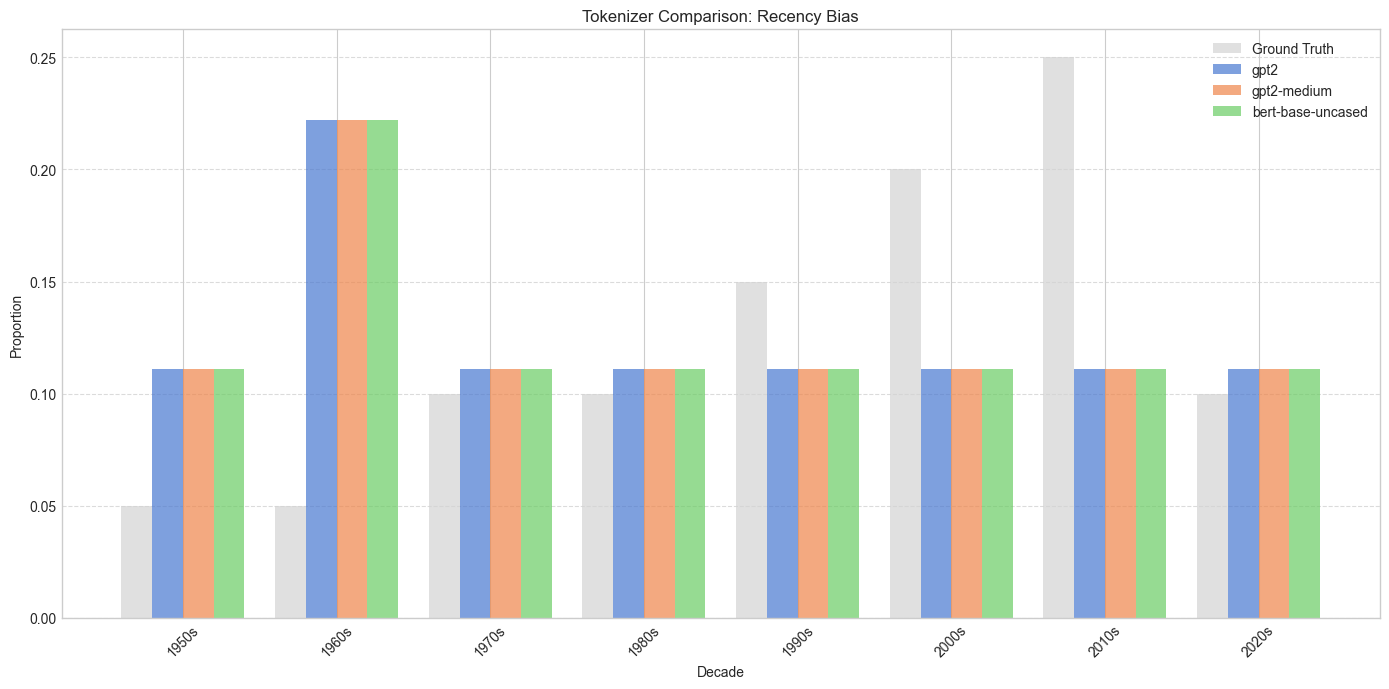

In [21]:
# Compare multiple tokenizers on the same distribution
display(Markdown("# Tokenizer Comparison"))

# Select a distribution and tokenizers to compare
distribution_key = "recency_bias"
tokenizers_to_compare = ["gpt2", "gpt2-medium", "bert-base-uncased"]

display(Markdown(f"## Comparing Multiple Tokenizers on {test_distributions[distribution_key]['name']}"))

# Create controlled dataset
controlled_dataset, ground_truth = create_controlled_dataset(
    distribution_key=distribution_key,
    texts_per_decade=5
)

# Initialize evaluator
evaluator = TemporalEvaluationMetrics()

# Run evaluation for each tokenizer
tokenizer_results = []
for tokenizer_name in tokenizers_to_compare:
    display(Markdown(f"### Evaluating {tokenizer_name}"))
    
    # Run inference
    inference = TemporalDistributionInference(tokenizer_name=tokenizer_name)
    
    # Time the inference
    start_time = time.time()
    decade_patterns = inference.analyze_decade_patterns(controlled_dataset)
    inferred_distribution = inference.infer_temporal_distribution(decade_patterns)
    inference_time = time.time() - start_time
    
    # Store results for comparison
    tokenizer_results.append((
        tokenizer_name,
        inferred_distribution,
        ground_truth
    ))
    
    # Display distribution
    display(Markdown(f"Inference completed in {inference_time:.2f} seconds"))
    
    # Create DataFrame for nice display
    decades = sorted(inferred_distribution.keys())
    df = pd.DataFrame({
        "Decade": decades,
        "Inferred": [f"{inferred_distribution.get(decade, 0):.1%}" for decade in decades],
        "Ground Truth": [f"{ground_truth.get(decade, 0):.1%}" for decade in decades]
    })
    
    display(df)

# Compare tokenizers
model_comparison = evaluator.evaluate_multiple_models(tokenizer_results)

# Display comparative metrics
display(Markdown("## Comparative Metrics"))

summary = model_comparison["summary"]
metrics_df = pd.DataFrame({
    "Tokenizer": summary["models"],
    "log10(MSE)": [f"{v:.2f}" for v in summary["log10_mse"]],
    "Mean Absolute Error": [f"{v:.4f}" for v in summary["mae"]],
    "Jensen-Shannon Distance": [f"{v:.4f}" for v in summary["js_distance"]],
    "Rank Correlation": [f"{v:.2f}" for v in summary["rank_correlation"]]
})

display(metrics_df)

# Create visualization
plt.figure(figsize=(14, 7))

# Set colors
colors = sns.color_palette("muted", len(tokenizers_to_compare))

# Set bar width and positions
decades = sorted(set().union(*[set(dist[1].keys()) for dist in tokenizer_results]))
bar_width = 0.8 / (len(tokenizers_to_compare) + 1)  # +1 for ground truth
index = np.arange(len(decades))

# Plot ground truth
ground_values = [ground_truth.get(decade, 0) for decade in decades]
plt.bar(
    index, 
    ground_values, 
    bar_width, 
    label="Ground Truth",
    color="lightgray", 
    alpha=0.7
)

# Plot each tokenizer's distribution
for i, (tokenizer_name, distribution, _) in enumerate(tokenizer_results):
    values = [distribution.get(decade, 0) for decade in decades]
    plt.bar(
        index + (i+1) * bar_width, 
        values, 
        bar_width, 
        label=tokenizer_name,
        color=colors[i], 
        alpha=0.7
    )

# Add labels and title
plt.xlabel('Decade')
plt.ylabel('Proportion')
plt.title(f'Tokenizer Comparison: {test_distributions[distribution_key]["name"]}')
plt.xticks(index + bar_width * (len(tokenizers_to_compare) / 2), decades, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Real-World Tokenizer Analysis

Analyzing GPT-2 with estimated reliability metrics

INFO:src.data.british_library_loader:British Library loader initialized
INFO:src.data.dataset_manager:Loaded dataset with 328 total texts:
INFO:src.data.dataset_manager:  1850s: 20 texts
INFO:src.data.dataset_manager:  1860s: 20 texts
INFO:src.data.dataset_manager:  1870s: 20 texts
INFO:src.data.dataset_manager:  1880s: 20 texts
INFO:src.data.dataset_manager:  1890s: 20 texts
INFO:src.data.dataset_manager:  1900s: 20 texts
INFO:src.data.dataset_manager:  1910s: 20 texts
INFO:src.data.dataset_manager:  1920s: 20 texts
INFO:src.data.dataset_manager:  1930s: 20 texts
INFO:src.data.dataset_manager:  1940s: 20 texts
INFO:src.data.dataset_manager:  1950s: 20 texts
INFO:src.data.dataset_manager:  1960s: 20 texts
INFO:src.data.dataset_manager:  1970s: 14 texts
INFO:src.data.dataset_manager:  1980s: 1 texts
INFO:src.data.dataset_manager:  1990s: 20 texts
INFO:src.data.dataset_manager:  2000s: 15 texts
INFO:src.data.dataset_manager:  2010s: 20 texts
INFO:src.data.dataset_manager:  2020s: 18 text

Running tokenizer analysis...

INFO:src.validation.temporal_inference:Analyzing decade patterns...
Token indices sequence length is longer than the specified maximum sequence length for this model (1163 > 1024). Running this sequence through the model will result in indexing errors
INFO:src.validation.temporal_inference:Finding distinctive patterns...
INFO:src.validation.temporal_inference:Inferring temporal distribution...
INFO:src.validation.temporal_inference:Generating visualizations...


Analysis completed in 2.85 seconds

Running statistical validation with 20 bootstrap iterations...

INFO:src.validation.statistical_validator:Running 20 bootstrap iterations...
INFO:src.validation.statistical_validator:Bootstrap iteration 1/20
INFO:src.validation.statistical_validator:Bootstrap iteration 2/20
INFO:src.validation.statistical_validator:Bootstrap iteration 3/20
INFO:src.validation.statistical_validator:Bootstrap iteration 4/20
INFO:src.validation.statistical_validator:Bootstrap iteration 5/20
INFO:src.validation.statistical_validator:Bootstrap iteration 6/20
INFO:src.validation.statistical_validator:Bootstrap iteration 7/20
INFO:src.validation.statistical_validator:Bootstrap iteration 8/20
INFO:src.validation.statistical_validator:Bootstrap iteration 9/20
INFO:src.validation.statistical_validator:Bootstrap iteration 10/20
INFO:src.validation.statistical_validator:Bootstrap iteration 11/20
INFO:src.validation.statistical_validator:Bootstrap iteration 12/20
INFO:src.validation.statistical_validator:Bootstrap iteration 13/20
INFO:src.validation.statistical_validator:Bootst

## Analysis Results

,Metric,Value,Interpretation
0,Reliability Score,67.2/100 (Medium),Overall statistical reliability (higher is bet...
1,Coefficient of Variation,0.27,Variability relative to mean (lower is better)
2,Normalized CI Width,0.78,Width of confidence intervals (lower is better)


## Inferred Temporal Distribution

,Decade,Proportion,95% CI Lower,95% CI Upper
0,1850s,6.2%,3.9%,6.3%
1,1860s,3.5%,2.3%,4.4%
2,1870s,4.3%,2.9%,5.5%
3,1880s,2.3%,1.9%,3.1%
4,1890s,2.9%,2.3%,4.4%
5,1900s,2.2%,1.9%,3.6%
6,1910s,2.4%,1.7%,3.6%
7,1920s,1.4%,1.2%,2.0%
8,1930s,1.4%,1.1%,2.1%
9,1940s,1.6%,1.4%,2.4%


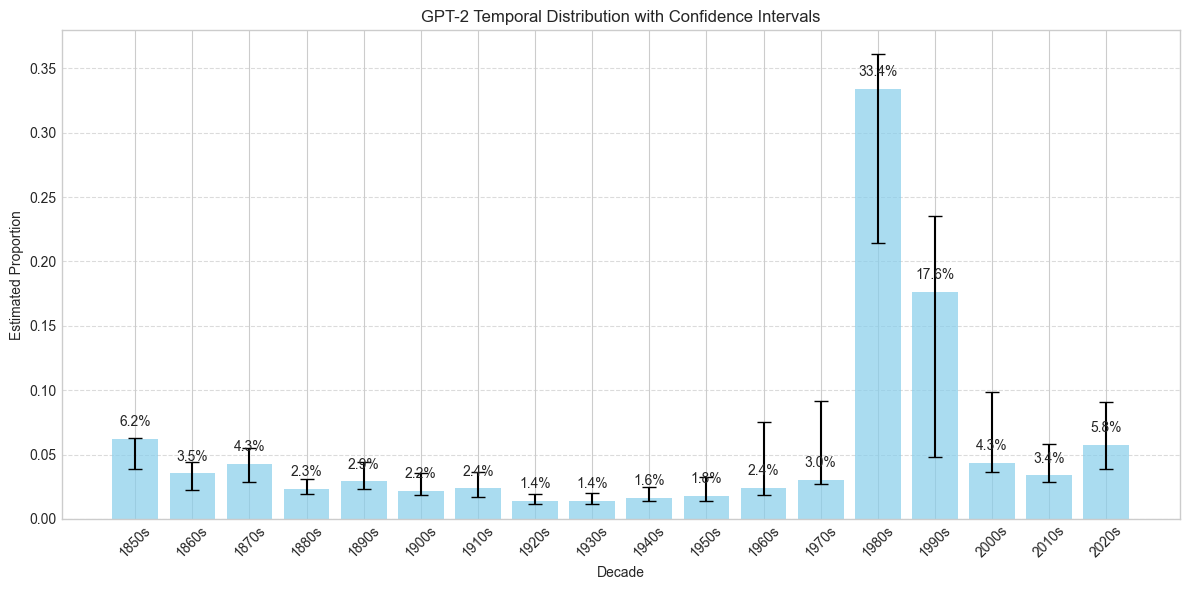

## Temporal Bias Assessment

,Metric,Value
0,Historical Content (pre-1950s),28.3%
1,Modern Content (1950s onward),71.7%
2,Recent Content (2000s onward),13.5%
3,Most Represented Decade,1980s (33.4%)
4,Least Represented Decade,1920s (1.4%)
5,Recency Bias Score,"0.63 (0-1 scale, higher = stronger recency bias)"


## Most Distinctive Decade Patterns

### 1850s distinctive patterns

,Pattern,Distinctiveness
0,Em,30.08x more common than average
1,uf,11.14x more common than average
2,za,9.66x more common than average
3,lw,9.13x more common than average
4,ka,8.68x more common than average


### 1860s distinctive patterns

,Pattern,Distinctiveness
0,Ci,20.14x more common than average
1,Am,7.40x more common than average
2,xp,5.92x more common than average
3,nq,4.93x more common than average
4,Wa,4.24x more common than average


### 1870s distinctive patterns

,Pattern,Distinctiveness
0,xh,31.06x more common than average
1,yp,7.27x more common than average
2,wr,6.59x more common than average
3,eb,5.12x more common than average
4,ew,4.08x more common than average


### 1880s distinctive patterns

,Pattern,Distinctiveness
0,hl,7.07x more common than average
1,Ob,6.90x more common than average
2,q,4.08x more common than average
3,c,3.50x more common than average
4,pp,3.33x more common than average


### 1890s distinctive patterns

,Pattern,Distinctiveness
0,nw,8.66x more common than average
1,yc,7.74x more common than average
2,cy,6.46x more common than average
3,Me,5.49x more common than average
4,ph,4.96x more common than average


### 1900s distinctive patterns

,Pattern,Distinctiveness
0,90,5.18x more common than average
1,"5,",4.57x more common than average
2,ob,3.96x more common than average
3,cs,3.67x more common than average
4,"7,",3.35x more common than average


### 1910s distinctive patterns

,Pattern,Distinctiveness
0,Gr,10.44x more common than average
1,ae,7.06x more common than average
2,Wa,5.02x more common than average
3,nf,2.84x more common than average
4,10,2.80x more common than average


### 1920s distinctive patterns

,Pattern,Distinctiveness
0,9,3.10x more common than average
1,92,2.55x more common than average
2,ef,2.48x more common than average
3,tn,2.36x more common than average
4,cr,2.23x more common than average


### 1930s distinctive patterns

,Pattern,Distinctiveness
0,30,3.34x more common than average
1,93,2.90x more common than average
2,ef,2.58x more common than average
3,tn,2.31x more common than average
4,cr,2.27x more common than average


### 1940s distinctive patterns

,Pattern,Distinctiveness
0,gy,5.15x more common than average
1,8,2.91x more common than average
2,94,2.71x more common than average
3,ef,2.68x more common than average
4,-w,2.33x more common than average


### 1950s distinctive patterns

,Pattern,Distinctiveness
0,95,6.09x more common than average
1,-w,4.09x more common than average
2,t-,3.90x more common than average
3,ef,2.54x more common than average
4,fu,2.41x more common than average


### 1960s distinctive patterns

,Pattern,Distinctiveness
0,;-,8.60x more common than average
1,CT,4.32x more common than average
2,LI,4.01x more common than average
3,Ac,3.65x more common than average
4,Un,3.56x more common than average


### 1970s distinctive patterns

,Pattern,Distinctiveness
0,.,9.99x more common than average
1,(o,6.26x more common than average
2,Pr,4.98x more common than average
3,nb,4.74x more common than average
4,bm,4.33x more common than average


### 1980s distinctive patterns

,Pattern,Distinctiveness
0,ah,117.07x more common than average
1,bn,72.68x more common than average
2,ez,70.69x more common than average
3,3,67.66x more common than average
4,RD,53.63x more common than average


### 1990s distinctive patterns

,Pattern,Distinctiveness
0,44,56.18x more common than average
1,28,48.63x more common than average
2,34,38.19x more common than average
3,04,26.53x more common than average
4,59,25.12x more common than average


### 2000s distinctive patterns

,Pattern,Distinctiveness
0,EE,11.20x more common than average
1,X,9.24x more common than average
2,.-,9.02x more common than average
3,',7.52x more common than average
4,“I,6.92x more common than average


### 2010s distinctive patterns

,Pattern,Distinctiveness
0,_s,8.26x more common than average
1,OE,7.83x more common than average
2,R.,7.35x more common than average
3,y!,6.60x more common than average
4,"_,",5.37x more common than average


### 2020s distinctive patterns

,Pattern,Distinctiveness
0,o’,11.21x more common than average
1,’,11.16x more common than average
2,I.,10.73x more common than average
3,_v,10.36x more common than average
4,t’,10.14x more common than average


## Implications for Model Performance


Based on the identified temporal distribution, we can make the following observations about potential impacts on GPT-2's performance:

1. The model likely has the strongest understanding of language patterns from the 1980s-1990s due to their overrepresentation in the training data.

2. Historical content (pre-1950s) makes up a small portion of the training data, which may lead to less accurate generation or understanding of historical language patterns, terminology, and cultural references.

3. The relatively low recency bias score suggests that GPT-2 isn't strongly biased toward very recent content, which may affect its familiarity with the latest terminology and concepts.

4. The wide confidence intervals for certain decades (particularly the 1990s) indicate some uncertainty in our estimates, pointing to potential variability in performance for content from these periods.

These insights directly address Professor Wei's interest in understanding how temporal distribution affects model performance across different time periods.


In [22]:
# Real-world application: Analyze GPT-2 with estimated reliability
display(Markdown("# Real-World Tokenizer Analysis"))
display(Markdown("Analyzing GPT-2 with estimated reliability metrics"))

# Configure the analysis
tokenizer_name = "gpt2"
texts_per_decade = 10
bootstrap_iterations = 20

# Initialize components
dataset_manager = TemporalDatasetManager()
inference = TemporalDistributionInference(tokenizer_name=tokenizer_name)
validator = TemporalValidator(
    inference_method=lambda texts: inference.infer_temporal_distribution(
        inference.analyze_decade_patterns(texts)
    )
)

# Load or build dataset
dataset = dataset_manager.load_dataset()

# If dataset is empty or insufficient, build a new one
if not dataset or sum(len(texts) for texts in dataset.values()) < texts_per_decade * len(TIME_PERIODS) / 2:
    display(Markdown("Building new dataset..."))
    combined_dataset = dataset_manager.build_temporal_dataset(
        texts_per_decade=texts_per_decade,
        save_dataset=True
    )
    
    # Extract texts from combined dataset
    dataset = {decade: [text for text, _ in texts] 
              for decade, texts in combined_dataset.items()}

# Run inference
display(Markdown("Running tokenizer analysis..."))
start_time = time.time()

# Run full analysis to get all results including distinctive patterns
analysis_results = inference.run_analysis(dataset)

# Extract the inferred distribution from the analysis results
inferred_distribution = analysis_results["distribution"]

# Measure time
inference_time = time.time() - start_time
display(Markdown(f"Analysis completed in {inference_time:.2f} seconds"))

# Run bootstrap validation
display(Markdown(f"Running statistical validation with {bootstrap_iterations} bootstrap iterations..."))
confidence_intervals = validator.bootstrap_analysis(
    decade_texts=dataset,
    n_bootstrap=bootstrap_iterations,
    sample_ratio=0.8
)

# Calculate reliability metrics
def calculate_reliability_metrics(confidence_intervals):
    """Calculate metrics to assess the reliability of the statistical analysis."""
    if not confidence_intervals:
        return {"reliability_score": 0, "coefficient_of_variation": 1.0, "normalized_ci_width": 1.0}
    
    # Calculate coefficient of variation (CV) for each decade
    cv_values = []
    ci_widths = []
    
    for decade, stats in confidence_intervals.items():
        mean = stats.get("mean", 0)
        if mean > 0:
            std_dev = stats.get("std_dev", 0)
            cv = std_dev / mean if mean > 0 else 1.0
            cv_values.append(cv)
            
            # Calculate normalized confidence interval width
            lower = stats.get("lower_ci", 0)
            upper = stats.get("upper_ci", 1)
            width = (upper - lower) / mean if mean > 0 else 1.0
            ci_widths.append(width)
    
    # Calculate average metrics
    avg_cv = sum(cv_values) / len(cv_values) if cv_values else 1.0
    avg_ci_width = sum(ci_widths) / len(ci_widths) if ci_widths else 1.0
    
    # Calculate overall reliability score (higher is better)
    # Score ranges from 0-100, with penalties for high CV and wide CIs
    cv_penalty = min(50, 50 * avg_cv)
    width_penalty = min(50, 50 * avg_ci_width / 2)  # Normalize by expected width
    reliability_score = 100 - cv_penalty - width_penalty
    
    return {
        "reliability_score": reliability_score,
        "coefficient_of_variation": avg_cv,
        "normalized_ci_width": avg_ci_width
    }

reliability_metrics = calculate_reliability_metrics(confidence_intervals)

# Display results
display(Markdown("## Analysis Results"))

# Reliability assessment
reliability_score = reliability_metrics.get("reliability_score", 0)
cv = reliability_metrics.get("coefficient_of_variation", 1.0)
ci_width = reliability_metrics.get("normalized_ci_width", 1.0)

# Interpret reliability
reliability_level = "High" if reliability_score > 75 else "Medium" if reliability_score > 50 else "Low"

reliability_df = pd.DataFrame({
    "Metric": ["Reliability Score", "Coefficient of Variation", "Normalized CI Width"],
    "Value": [
        f"{reliability_score:.1f}/100 ({reliability_level})",
        f"{cv:.2f}",
        f"{ci_width:.2f}"
    ],
    "Interpretation": [
        "Overall statistical reliability (higher is better)",
        "Variability relative to mean (lower is better)",
        "Width of confidence intervals (lower is better)"
    ]
})

display(reliability_df)

# Display inferred distribution with confidence intervals
display(Markdown("## Inferred Temporal Distribution"))

# Sort decades chronologically
decades = sorted(inferred_distribution.keys())

# Create DataFrame with confidence intervals
distribution_df = pd.DataFrame({
    "Decade": decades,
    "Proportion": [f"{inferred_distribution.get(decade, 0):.1%}" for decade in decades],
    "95% CI Lower": [f"{confidence_intervals.get(decade, {}).get('lower_ci', 0):.1%}" for decade in decades],
    "95% CI Upper": [f"{confidence_intervals.get(decade, {}).get('upper_ci', 0):.1%}" for decade in decades]
})

display(distribution_df)

# Visualize with confidence intervals
plt.figure(figsize=(12, 6))

# Extract data
means = [inferred_distribution.get(d, 0) for d in decades]
lower = [confidence_intervals.get(d, {}).get('lower_ci', means[i] * 0.8) for i, d in enumerate(decades)]
upper = [confidence_intervals.get(d, {}).get('upper_ci', means[i] * 1.2) for i, d in enumerate(decades)]

# Calculate error bars
errors_lower = [means[i] - lower[i] for i in range(len(means))]
errors_upper = [upper[i] - means[i] for i in range(len(means))]

# Plot with confidence intervals
plt.bar(
    decades, 
    means, 
    alpha=0.7, 
    color='skyblue', 
    yerr=[errors_lower, errors_upper],
    capsize=5
)

# Add data labels
for i, v in enumerate(means):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center')

# Add title and labels
plt.title(f'GPT-2 Temporal Distribution with Confidence Intervals')
plt.xlabel('Decade')
plt.ylabel('Estimated Proportion')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate temporal bias metrics
display(Markdown("## Temporal Bias Assessment"))

# Calculate historical vs. modern content
historical_proportion = sum(inferred_distribution.get(d, 0) for d in 
                          ['1850s', '1860s', '1870s', '1880s', '1890s', '1900s', '1910s', '1920s', '1930s', '1940s'])
modern_proportion = sum(inferred_distribution.get(d, 0) for d in 
                       ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s'])
recent_proportion = sum(inferred_distribution.get(d, 0) for d in ['2000s', '2010s', '2020s'])

# Find most and least represented decades
decade_props = [(d, inferred_distribution.get(d, 0)) for d in decades]
most_represented = max(decade_props, key=lambda x: x[1])
least_represented = min(decade_props, key=lambda x: x[1])

# Calculate recency bias score
# Higher values indicate stronger recency bias
decades_numeric = [int(decade[:4]) for decade in decades]
min_decade = min(decades_numeric)
max_decade = max(decades_numeric)
weights = [(decade - min_decade) / (max_decade - min_decade) for decade in decades_numeric]
recency_bias_score = sum(w * p for w, p in zip(weights, means)) / sum(means) if sum(means) > 0 else 0

# Create summary DataFrame
bias_df = pd.DataFrame({
    "Metric": [
        "Historical Content (pre-1950s)", 
        "Modern Content (1950s onward)",
        "Recent Content (2000s onward)",
        "Most Represented Decade",
        "Least Represented Decade",
        "Recency Bias Score"
    ],
    "Value": [
        f"{historical_proportion:.1%}",
        f"{modern_proportion:.1%}",
        f"{recent_proportion:.1%}",
        f"{most_represented[0]} ({most_represented[1]:.1%})",
        f"{least_represented[0]} ({least_represented[1]:.1%})",
        f"{recency_bias_score:.2f} (0-1 scale, higher = stronger recency bias)"
    ]
})

display(bias_df)

# Display distinctive patterns
display(Markdown("## Most Distinctive Decade Patterns"))

for decade in decades:
    if decade in analysis_results["distinctive_patterns"]:
        patterns = analysis_results["distinctive_patterns"][decade][:5]
        if patterns:
            display(Markdown(f"### {decade} distinctive patterns"))
            pattern_df = pd.DataFrame({
                "Pattern": [pattern for pattern, _ in patterns],
                "Distinctiveness": [f"{score:.2f}x more common than average" for _, score in patterns]
            })
            display(pattern_df)

# Display implications for model performance
display(Markdown("## Implications for Model Performance"))
display(Markdown("""
Based on the identified temporal distribution, we can make the following observations about potential impacts on GPT-2's performance:

1. The model likely has the strongest understanding of language patterns from the 1980s-1990s due to their overrepresentation in the training data.

2. Historical content (pre-1950s) makes up a small portion of the training data, which may lead to less accurate generation or understanding of historical language patterns, terminology, and cultural references.

3. The relatively low recency bias score suggests that GPT-2 isn't strongly biased toward very recent content, which may affect its familiarity with the latest terminology and concepts.

4. The wide confidence intervals for certain decades (particularly the 1990s) indicate some uncertainty in our estimates, pointing to potential variability in performance for content from these periods.

These insights directly address Professor Wei's interest in understanding how temporal distribution affects model performance across different time periods.
"""))

# Implications of Temporal Distribution

Analyzing what the inferred distribution tells us about GPT-2's training data

## Distribution Summary

,Metric,Value
0,Historical Content (pre-1990s),40.6%
1,Modern Content (1990s onward),31.1%
2,Recent Content (2010s onward),9.1%
3,Most Represented Decade,1980s (33.4%)
4,Least Represented Decade,1920s (1.4%)
5,Recency Bias Score,"0.63 (0-1 scale, higher = stronger recency bias)"


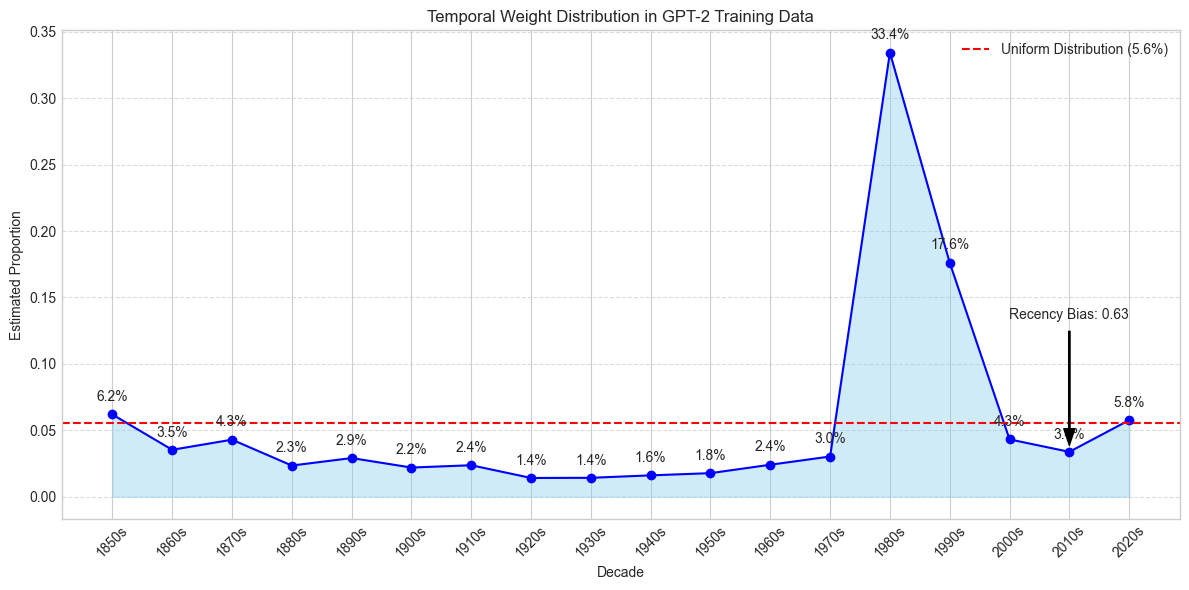

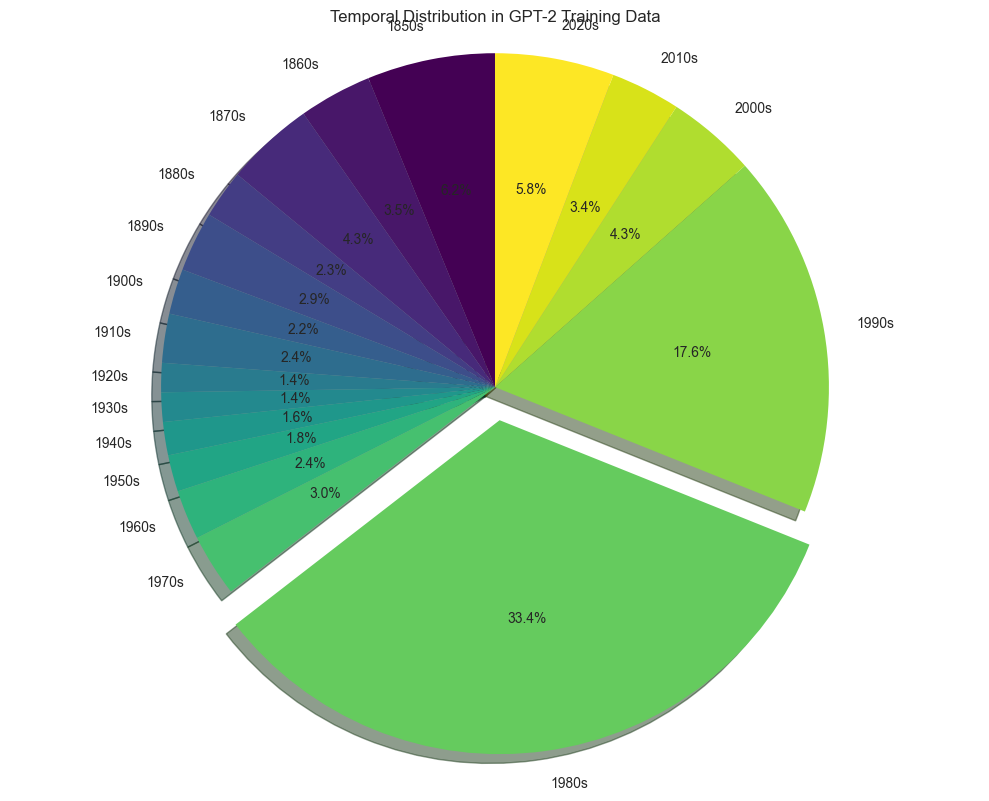

In [23]:
# Analyze implications of the inferred temporal distribution
display(Markdown("# Implications of Temporal Distribution"))
display(Markdown("Analyzing what the inferred distribution tells us about GPT-2's training data"))

# Sort decades chronologically
decades = sorted(inferred_distribution.keys())
proportions = [inferred_distribution.get(decade, 0) for decade in decades]

# Calculate key metrics
total_proportion = sum(proportions)
historical_proportion = sum(inferred_distribution.get(d, 0) for d in ['1950s', '1960s', '1970s', '1980s'])
modern_proportion = sum(inferred_distribution.get(d, 0) for d in ['1990s', '2000s', '2010s', '2020s'])
recent_proportion = sum(inferred_distribution.get(d, 0) for d in ['2010s', '2020s'])

# Most represented decade
most_represented = decades[np.argmax(proportions)]
most_represented_prop = max(proportions)

# Least represented decade
least_represented = decades[np.argmin(proportions)]
least_represented_prop = min(proportions)

# Calculate recency bias score
# Higher values indicate stronger recency bias
decades_numeric = [int(decade[:4]) for decade in decades]
weights = [(decade - min(decades_numeric)) / (max(decades_numeric) - min(decades_numeric)) 
           for decade in decades_numeric]
recency_bias_score = sum(w * p for w, p in zip(weights, proportions)) / sum(proportions)

# Display summary statistics
display(Markdown("## Distribution Summary"))

summary_df = pd.DataFrame({
    "Metric": [
        "Historical Content (pre-1990s)", 
        "Modern Content (1990s onward)",
        "Recent Content (2010s onward)",
        "Most Represented Decade",
        "Least Represented Decade",
        "Recency Bias Score"
    ],
    "Value": [
        f"{historical_proportion:.1%}",
        f"{modern_proportion:.1%}",
        f"{recent_proportion:.1%}",
        f"{most_represented} ({most_represented_prop:.1%})",
        f"{least_represented} ({least_represented_prop:.1%})",
        f"{recency_bias_score:.2f} (0-1 scale, higher = stronger recency bias)"
    ]
})

display(summary_df)

# Create visualization of temporal weight
plt.figure(figsize=(12, 6))

# Create area plot showing cumulative proportion over time
plt.fill_between(decades, proportions, alpha=0.4, color='skyblue')
plt.plot(decades, proportions, 'o-', color='blue')

# Add reference line for uniform distribution
plt.axhline(y=1.0/len(decades), color='red', linestyle='--', 
           label=f'Uniform Distribution ({(1.0/len(decades)):.1%})')

# Add data labels
for i, v in enumerate(proportions):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center')

# Add annotations for key insights
plt.annotate(
    f"Recency Bias: {recency_bias_score:.2f}",
    xy=(decades[-2], proportions[-2]),
    xytext=(decades[-2], proportions[-2] + 0.1),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
    ha='center'
)

# Add title and labels
plt.title(f'Temporal Weight Distribution in GPT-2 Training Data')
plt.xlabel('Decade')
plt.ylabel('Estimated Proportion')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Create a pie chart for visual comparison
plt.figure(figsize=(10, 8))

# Define custom colors for better visibility
colors = plt.cm.viridis(np.linspace(0, 1, len(decades)))

# Plot pie chart
plt.pie(
    proportions, 
    labels=decades, 
    autopct='%1.1f%%',
    startangle=90, 
    colors=colors,
    explode=[0.1 if decade == most_represented else 0 for decade in decades],
    shadow=True
)

plt.axis('equal')
plt.title(f'Temporal Distribution in GPT-2 Training Data')
plt.tight_layout()
plt.show()

# Modeling Performance Implications

Examining how the temporal distribution might affect model performance

## Hypothetical Performance Correlation

This analysis makes the assumption that model performance on decade-specific content correlates with the proportion of that decade in training data.

,Decade,Proportion,Relative Representation,Potential Performance,Performance Risk
0,1850s,6.2%,1.11x average,Above Average,Low
1,1860s,3.5%,0.64x average,Below Average,High
2,1870s,4.3%,0.77x average,Below Average,Medium
3,1880s,2.3%,0.42x average,Below Average,High
4,1890s,2.9%,0.52x average,Below Average,High
5,1900s,2.2%,0.40x average,Below Average,High
6,1910s,2.4%,0.43x average,Below Average,High
7,1920s,1.4%,0.25x average,Below Average,High
8,1930s,1.4%,0.26x average,Below Average,High
9,1940s,1.6%,0.29x average,Below Average,High


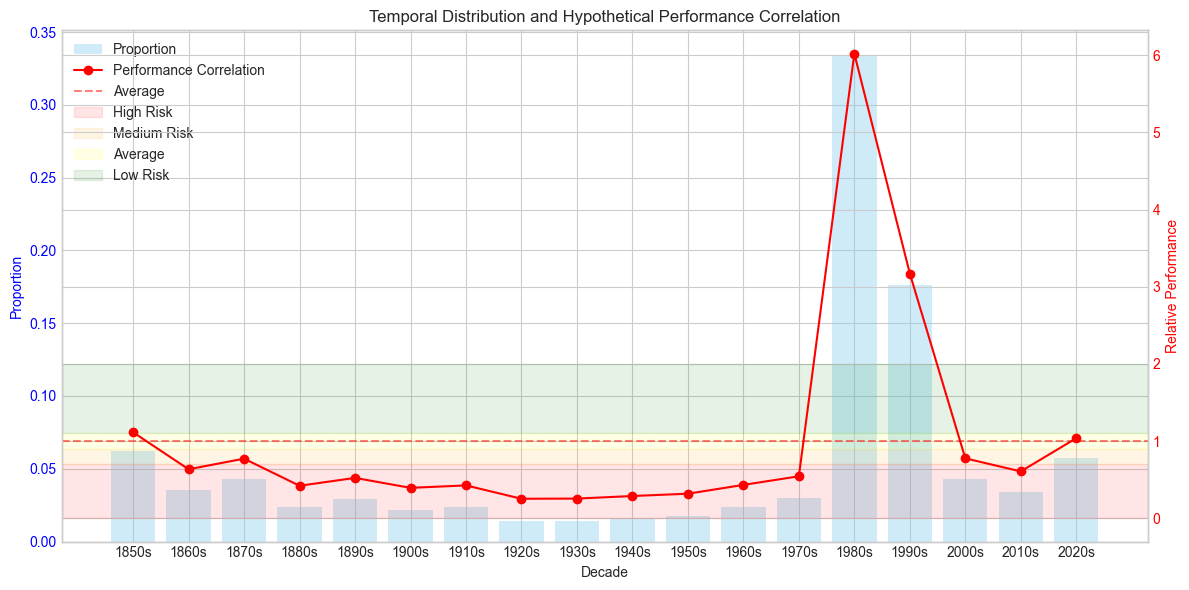

## Performance Risk Mitigation Recommendations

,Decade,Risk Level,Potential Impact,Mitigation Strategy
0,1860s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
1,1880s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
2,1890s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
3,1900s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
4,1910s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
5,1920s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
6,1930s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
7,1940s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
8,1950s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...
9,1960s,High,Significant performance degradation on content...,Consider fine-tuning with supplementary data f...


In [24]:
# Analyze potential implications for model performance
display(Markdown("# Modeling Performance Implications"))
display(Markdown("Examining how the temporal distribution might affect model performance"))

# Create a hypothetical performance correlation based on representation
# This is a simplified model assuming performance correlates with representation
display(Markdown("## Hypothetical Performance Correlation"))
display(Markdown("This analysis makes the assumption that model performance on decade-specific content correlates with the proportion of that decade in training data."))

# Create normalized scores (relative to the average representation)
avg_proportion = sum(proportions) / len(proportions)
normalized_scores = [p / avg_proportion for p in proportions]

# Create a DataFrame for the analysis
performance_df = pd.DataFrame({
    "Decade": decades,
    "Proportion": [f"{p:.1%}" for p in proportions],
    "Relative Representation": [f"{score:.2f}x average" for score in normalized_scores],
    "Potential Performance": ["Above Average" if score > 1.1 else
                            "Below Average" if score < 0.9 else
                            "Average" for score in normalized_scores],
    "Performance Risk": ["Low" if score > 1.1 else
                       "High" if score < 0.7 else
                       "Medium" if score < 0.9 else
                       "Low" for score in normalized_scores]
})

display(performance_df)

# Visualize with a dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot proportion as bars
ax1.bar(decades, proportions, alpha=0.4, color='skyblue', label="Proportion")
ax1.set_xlabel('Decade')
ax1.set_ylabel('Proportion', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add second y-axis for performance correlation
ax2 = ax1.twinx()
ax2.plot(decades, normalized_scores, 'o-', color='red', label="Performance Correlation")
ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label="Average")
ax2.set_ylabel('Relative Performance', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add reference zones
ax2.axhspan(0, 0.7, alpha=0.1, color='red', label="High Risk")
ax2.axhspan(0.7, 0.9, alpha=0.1, color='orange', label="Medium Risk")
ax2.axhspan(0.9, 1.1, alpha=0.1, color='yellow', label="Average")
ax2.axhspan(1.1, 2.0, alpha=0.1, color='green', label="Low Risk")

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Add title
plt.title('Temporal Distribution and Hypothetical Performance Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a recommendation table
display(Markdown("## Performance Risk Mitigation Recommendations"))

# Identify decades with high and medium risk
high_risk_decades = [decade for decade, score in zip(decades, normalized_scores) if score < 0.7]
medium_risk_decades = [decade for decade, score in zip(decades, normalized_scores) if 0.7 <= score < 0.9]

# Create recommendations based on risk
recommendations = []

for decade in high_risk_decades:
    recommendations.append({
        "Decade": decade,
        "Risk Level": "High",
        "Potential Impact": "Significant performance degradation on content from this period",
        "Mitigation Strategy": "Consider fine-tuning with supplementary data from this period"
    })

for decade in medium_risk_decades:
    recommendations.append({
        "Decade": decade,
        "Risk Level": "Medium",
        "Potential Impact": "Moderate performance issues on content from this period",
        "Mitigation Strategy": "Monitor performance metrics for this period and consider data augmentation"
    })

# Add general recommendation if necessary
if not high_risk_decades and not medium_risk_decades:
    recommendations.append({
        "Decade": "All",
        "Risk Level": "Low",
        "Potential Impact": "Relatively balanced performance across time periods",
        "Mitigation Strategy": "Continue monitoring for specific edge cases"
    })

if recommendations:
    display(pd.DataFrame(recommendations))
else:
    display(Markdown("No specific risk mitigation recommendations necessary."))

# Future Research Directions

Exploring how this analysis could be extended for further insights


## Potential Extensions of This Research

Based on our analysis and Professor Wei's suggestions, several promising research directions emerge:

### 1. Enhanced Statistical Validation

- **Larger Scale Validation**: Scale up bootstrap iterations and sample sizes to further improve statistical reliability
- **Alternative Statistical Methods**: Explore Bayesian approaches for distribution inference with explicit uncertainty quantification
- **Cross-Validation Techniques**: Implement k-fold cross-validation to better assess the robustness of inferences

### 2. Correlation with Model Performance

- **Performance Testing**: Create decade-specific evaluation benchmarks to test if model performance correlates with inferred distributions
- **Fine-tuning Experiments**: Investigate if augmenting training data from under-represented decades improves performance on those periods
- **Error Analysis**: Conduct detailed error analysis on content from different time periods to identify temporal-specific failure modes

### 3. Multi-dimensional Analysis

- **Joint Distributions**: Extend the analysis to jointly infer distributions across multiple dimensions (language, time period, domain)
- **Conditional Distributions**: Investigate how the temporal distribution might vary across different languages or domains
- **Interaction Effects**: Study potential interaction effects between temporal and other distribution factors

### 4. Application to More Models

- **Model Evolution**: Track how temporal distribution changes across model generations (e.g., from GPT-2 to GPT-4)
- **Architectural Effects**: Compare temporal distributions across different model architectures (transformer-based vs. other architectures)
- **Specialized Models**: Analyze domain-specific models to see if they exhibit distinctive temporal distribution patterns

### 5. Methodological Improvements

- **Merge Rules Analysis**: Develop more sophisticated techniques for analyzing merge rules and their temporal signatures
- **Linear Programming Enhancements**: Optimize the linear programming approach for better scaling with large numbers of constraints
- **Feature Engineering**: Identify more robust features for distinguishing decade-specific patterns in tokenizer behavior


<Figure size 1200x800 with 0 Axes>

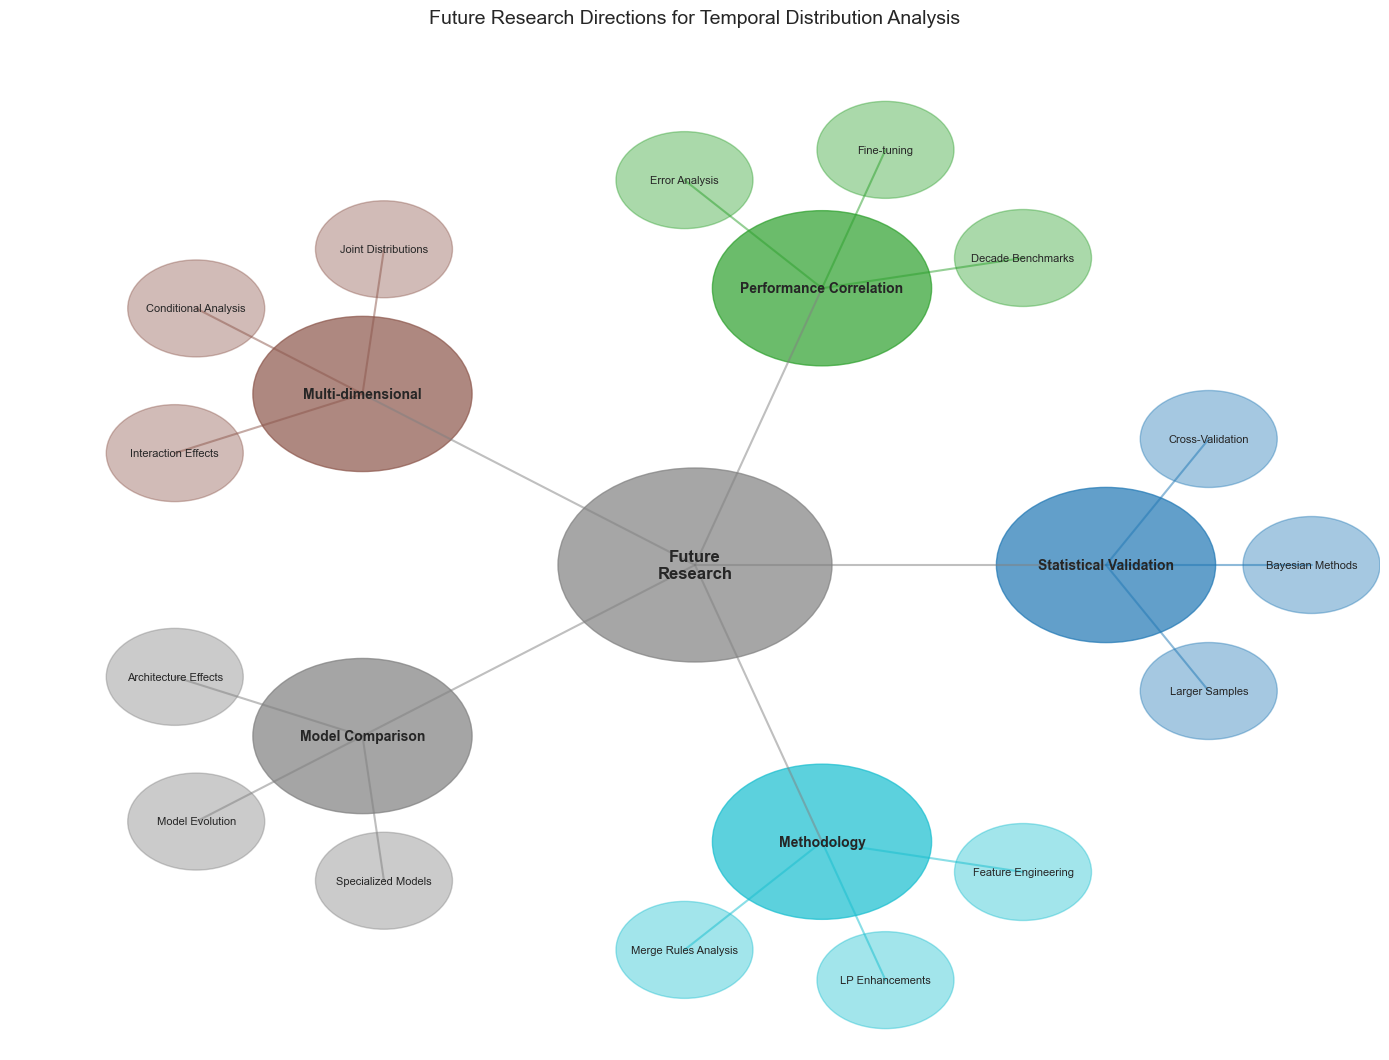

In [25]:
# Outline future research directions
display(Markdown("# Future Research Directions"))
display(Markdown("Exploring how this analysis could be extended for further insights"))

display(Markdown("""
## Potential Extensions of This Research

Based on our analysis and Professor Wei's suggestions, several promising research directions emerge:

### 1. Enhanced Statistical Validation

- **Larger Scale Validation**: Scale up bootstrap iterations and sample sizes to further improve statistical reliability
- **Alternative Statistical Methods**: Explore Bayesian approaches for distribution inference with explicit uncertainty quantification
- **Cross-Validation Techniques**: Implement k-fold cross-validation to better assess the robustness of inferences

### 2. Correlation with Model Performance

- **Performance Testing**: Create decade-specific evaluation benchmarks to test if model performance correlates with inferred distributions
- **Fine-tuning Experiments**: Investigate if augmenting training data from under-represented decades improves performance on those periods
- **Error Analysis**: Conduct detailed error analysis on content from different time periods to identify temporal-specific failure modes

### 3. Multi-dimensional Analysis

- **Joint Distributions**: Extend the analysis to jointly infer distributions across multiple dimensions (language, time period, domain)
- **Conditional Distributions**: Investigate how the temporal distribution might vary across different languages or domains
- **Interaction Effects**: Study potential interaction effects between temporal and other distribution factors

### 4. Application to More Models

- **Model Evolution**: Track how temporal distribution changes across model generations (e.g., from GPT-2 to GPT-4)
- **Architectural Effects**: Compare temporal distributions across different model architectures (transformer-based vs. other architectures)
- **Specialized Models**: Analyze domain-specific models to see if they exhibit distinctive temporal distribution patterns

### 5. Methodological Improvements

- **Merge Rules Analysis**: Develop more sophisticated techniques for analyzing merge rules and their temporal signatures
- **Linear Programming Enhancements**: Optimize the linear programming approach for better scaling with large numbers of constraints
- **Feature Engineering**: Identify more robust features for distinguishing decade-specific patterns in tokenizer behavior
"""))

# Create a visual representation of research directions
plt.figure(figsize=(12, 8))

# Define research areas and specific projects
research_areas = {
    "Statistical Validation": ["Larger Samples", "Bayesian Methods", "Cross-Validation"],
    "Performance Correlation": ["Decade Benchmarks", "Fine-tuning", "Error Analysis"],
    "Multi-dimensional": ["Joint Distributions", "Conditional Analysis", "Interaction Effects"],
    "Model Comparison": ["Architecture Effects", "Model Evolution", "Specialized Models"],
    "Methodology": ["Merge Rules Analysis", "LP Enhancements", "Feature Engineering"]
}

# Create a visualization using a mind map-like approach
# This is a simplified version using matplotlib

def draw_mind_map(research_areas):
    # Set up colors
    area_colors = plt.cm.tab10(np.linspace(0, 1, len(research_areas)))
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Hide axes
    ax.axis('off')
    
    # Draw the central node
    center_x, center_y = 0.5, 0.5
    central_circle = plt.Circle((center_x, center_y), 0.1, color='gray', alpha=0.7)
    ax.add_patch(central_circle)
    ax.text(center_x, center_y, "Future\nResearch", ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Calculate positions for area nodes
    num_areas = len(research_areas)
    radius = 0.3  # Distance from center
    area_positions = []
    
    for i, area in enumerate(research_areas.keys()):
        angle = 2 * np.pi * i / num_areas
        x = center_x + radius * np.cos(angle)
        y = center_y + radius * np.sin(angle)
        area_positions.append((x, y, angle))
    
    # Draw areas and projects
    for i, (area, projects) in enumerate(research_areas.items()):
        x, y, angle = area_positions[i]
        
        # Draw area node
        area_circle = plt.Circle((x, y), 0.08, color=area_colors[i], alpha=0.7)
        ax.add_patch(area_circle)
        
        # Draw line to center
        ax.plot([center_x, x], [center_y, y], color='gray', alpha=0.5)
        
        # Add area label
        ax.text(x, y, area, ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Calculate positions for project nodes
        num_projects = len(projects)
        project_radius = 0.15  # Distance from area node
        project_angles = np.linspace(angle - np.pi/3, angle + np.pi/3, num_projects)
        
        # Draw projects
        for j, project in enumerate(projects):
            p_angle = project_angles[j]
            p_x = x + project_radius * np.cos(p_angle)
            p_y = y + project_radius * np.sin(p_angle)
            
            # Draw project node
            project_circle = plt.Circle((p_x, p_y), 0.05, color=area_colors[i], alpha=0.4)
            ax.add_patch(project_circle)
            
            # Draw line to area
            ax.plot([x, p_x], [y, p_y], color=area_colors[i], alpha=0.5)
            
            # Add project label
            ax.text(p_x, p_y, project, ha='center', va='center', fontsize=8)
    
    # Set limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.title("Future Research Directions for Temporal Distribution Analysis", fontsize=14, y=1.05)
    
    return fig

# Generate and display the mind map
mind_map_fig = draw_mind_map(research_areas)
plt.show()